<a href="https://www.kaggle.com/competitions/playground-series-s4e6/discussion/487170">Kaggle - Classification with an Academic Success Dataset
</a>
 - Playground Series - Season 4, Episode 6

# Install

In [ ]:
!pip install lightgbm
!pip install xgboost optuna

# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score,ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,VotingClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, RFE
import lightgbm as lgb
from lightgbm import LGBMClassifier
import optuna
import os
import plotly.express as px
from plotly.offline import iplot
import xgboost as xgb
import optuna
from sklearn.neighbors import KNeighborsClassifier
from datetime import datetime

%matplotlib inline

# Get the data

In [ ]:
#Train data
train = pd.read_csv('train.csv', index_col='id')
#Test data (aka t "real test")
real_test =  pd.read_csv('test.csv', index_col='id')


In [ ]:
#Customised Labeling for the target
def convert_to_int(x):
  try:
    return int(x)
  except ValueError:
    if x == 'Graduate':
        return 1
    else:
        if x=='Enrolled':
          return 2
        else:
          return 3

In [ ]:
train.head(5)

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
id,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,9238,1,1,126.0,1,1,19,...,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate
1,1,17,1,9238,1,1,125.0,1,19,19,...,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout
2,1,17,2,9254,1,1,137.0,1,3,19,...,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout
3,1,1,3,9500,1,1,131.0,1,19,3,...,0,8,11,7,12.820000,0,11.1,0.6,2.02,Enrolled
4,1,1,2,9500,1,1,132.0,1,19,37,...,0,7,12,6,12.933333,0,7.6,2.6,0.32,Graduate


# EDA

## General

In [ ]:
train.shape

(76518, 37)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76518 entries, 0 to 76517
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  76518 non-null  int64  
 1   Application mode                                76518 non-null  int64  
 2   Application order                               76518 non-null  int64  
 3   Course                                          76518 non-null  int64  
 4   Daytime/evening attendance                      76518 non-null  int64  
 5   Previous qualification                          76518 non-null  int64  
 6   Previous qualification (grade)                  76518 non-null  float64
 7   Nacionality                                     76518 non-null  int64  
 8   Mother's qualification                          76518 non-null  int64  
 9   Father's qualification                      

In [ ]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Marital status,76518.0,1.111934,0.441669,1.00,1.000000,1.000000,1.000000,6.000
Application mode,76518.0,16.054419,16.682337,1.00,1.000000,17.000000,39.000000,53.000
Application order,76518.0,1.644410,1.229645,0.00,1.000000,1.000000,2.000000,9.000
Course,76518.0,9001.286377,1803.438531,33.00,9119.000000,9254.000000,9670.000000,9991.000
Daytime/evening attendance,76518.0,0.915314,0.278416,0.00,1.000000,1.000000,1.000000,1.000
Previous qualification,76518.0,3.658760,8.623774,1.00,1.000000,1.000000,1.000000,43.000
Previous qualification (grade),76518.0,132.378766,10.995328,95.00,125.000000,133.100000,140.000000,190.000
Nacionality,76518.0,1.226600,3.392183,1.00,1.000000,1.000000,1.000000,109.000
Mother's qualification,76518.0,19.837633,15.399456,1.00,1.000000,19.000000,37.000000,44.000
Father's qualification,76518.0,23.425076,14.921164,1.00,4.000000,19.000000,37.000000,44.000


In [ ]:
train.isna().sum()

Marital status                                    0
Application mode                                  0
Application order                                 0
Course                                            0
Daytime/evening attendance                        0
Previous qualification                            0
Previous qualification (grade)                    0
Nacionality                                       0
Mother's qualification                            0
Father's qualification                            0
Mother's occupation                               0
Father's occupation                               0
Admission grade                                   0
Displaced                                         0
Educational special needs                         0
Debtor                                            0
Tuition fees up to date                           0
Gender                                            0
Scholarship holder                                0
Age at enrol

## Plots

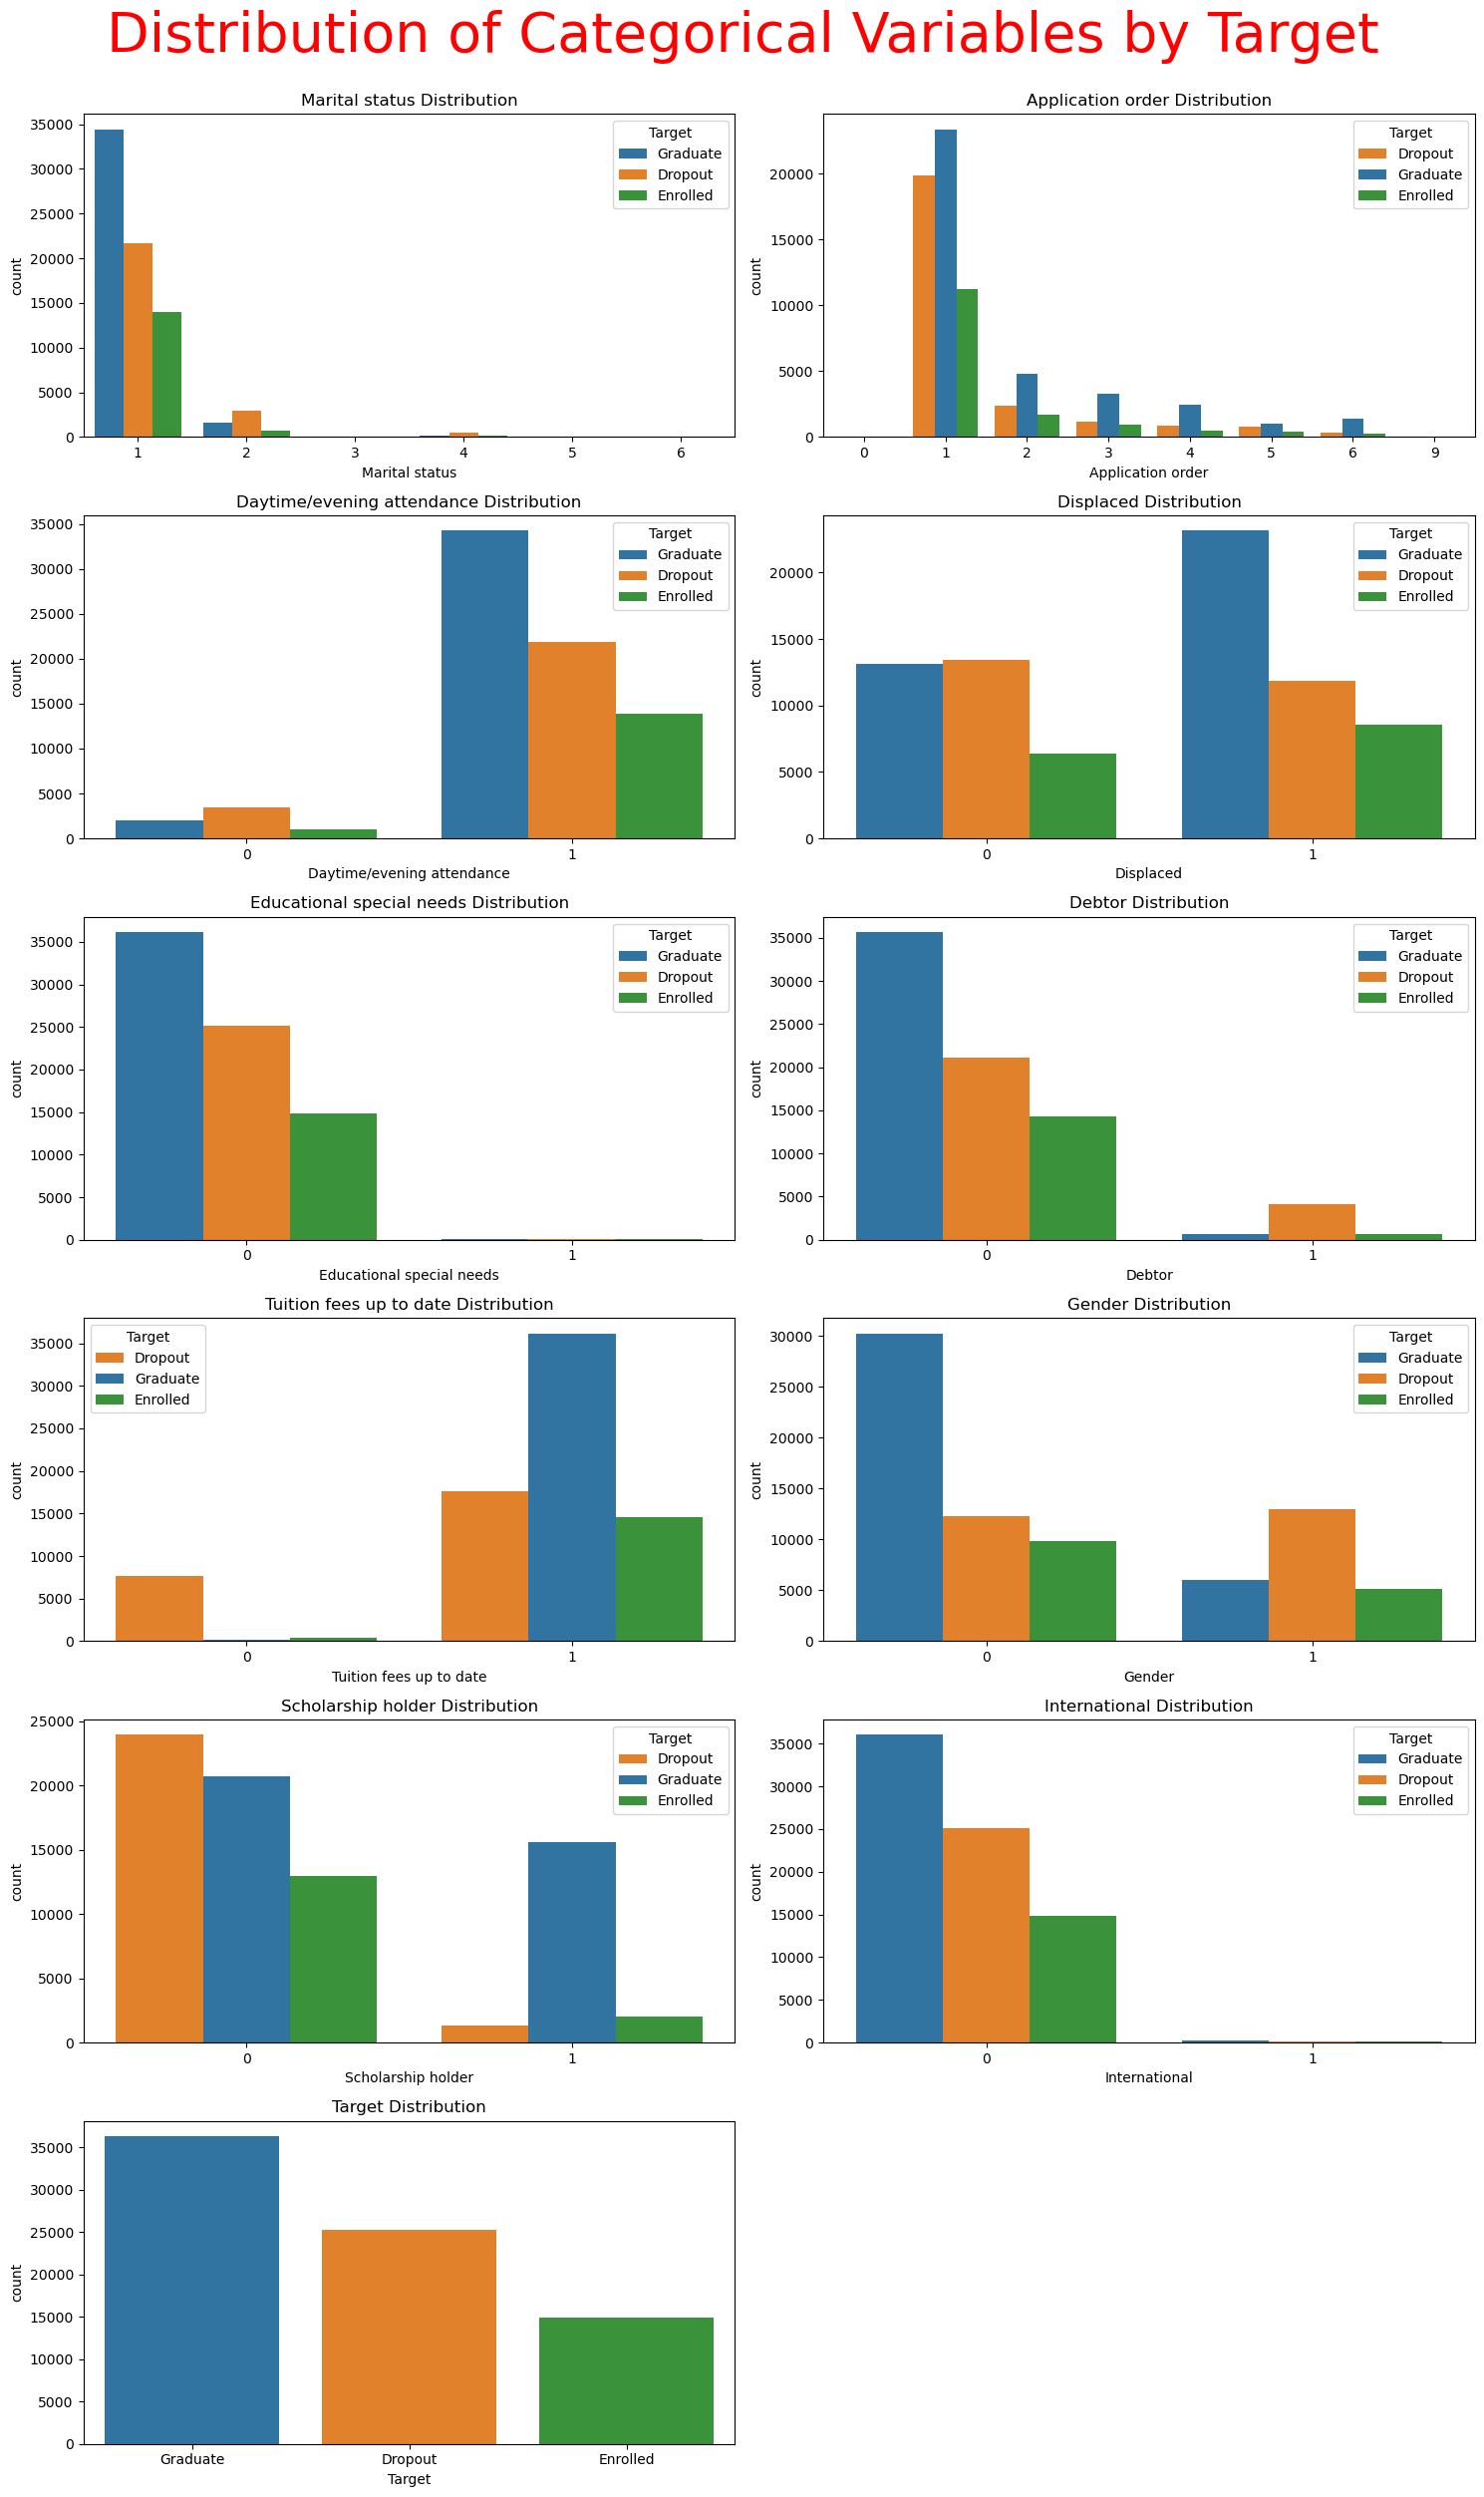

In [ ]:
#Distribution of Catagory columns by target
cat_columns = [column for column in train.columns if train[column].nunique() <= 10]

target_levels = train['Target'].unique()

palette = sns.color_palette(None, len(target_levels))

palette_dict = {level: palette[i] for i, level in enumerate(target_levels)}

num_cols = 2
num_rows = (len(cat_columns) + num_cols - 1) // num_cols

plt.figure(figsize=(15, 25))
for i, column in enumerate(cat_columns):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.countplot(data=train, x=column, hue='Target', palette=palette_dict)
    plt.title(f'{column} Distribution')
plt.suptitle('Distribution of Categorical Variables by Target', fontsize=40, y=1, color='red')
plt.tight_layout()
plt.show()

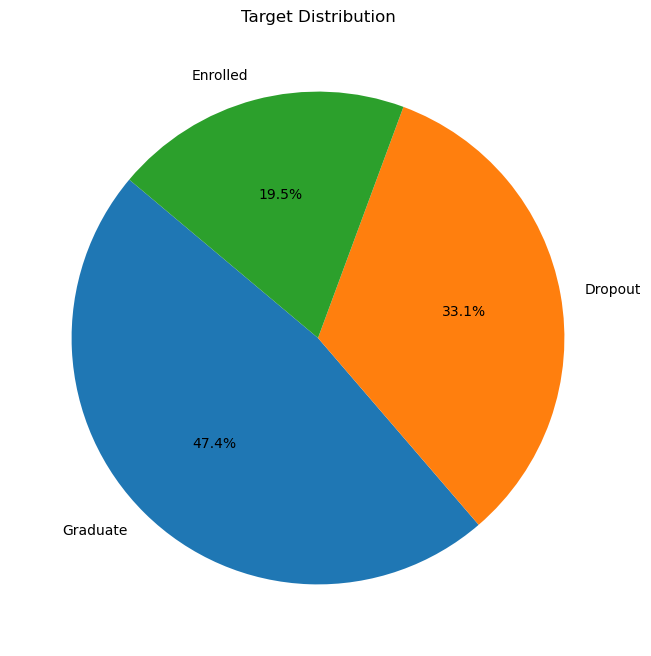

In [ ]:
#Pie chart of Target distribution
category_counts = train['Target'].value_counts()
colors = [palette_dict[level] for level in category_counts.index]
plt.figure(figsize=(8, 8))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Target Distribution')
plt.show()

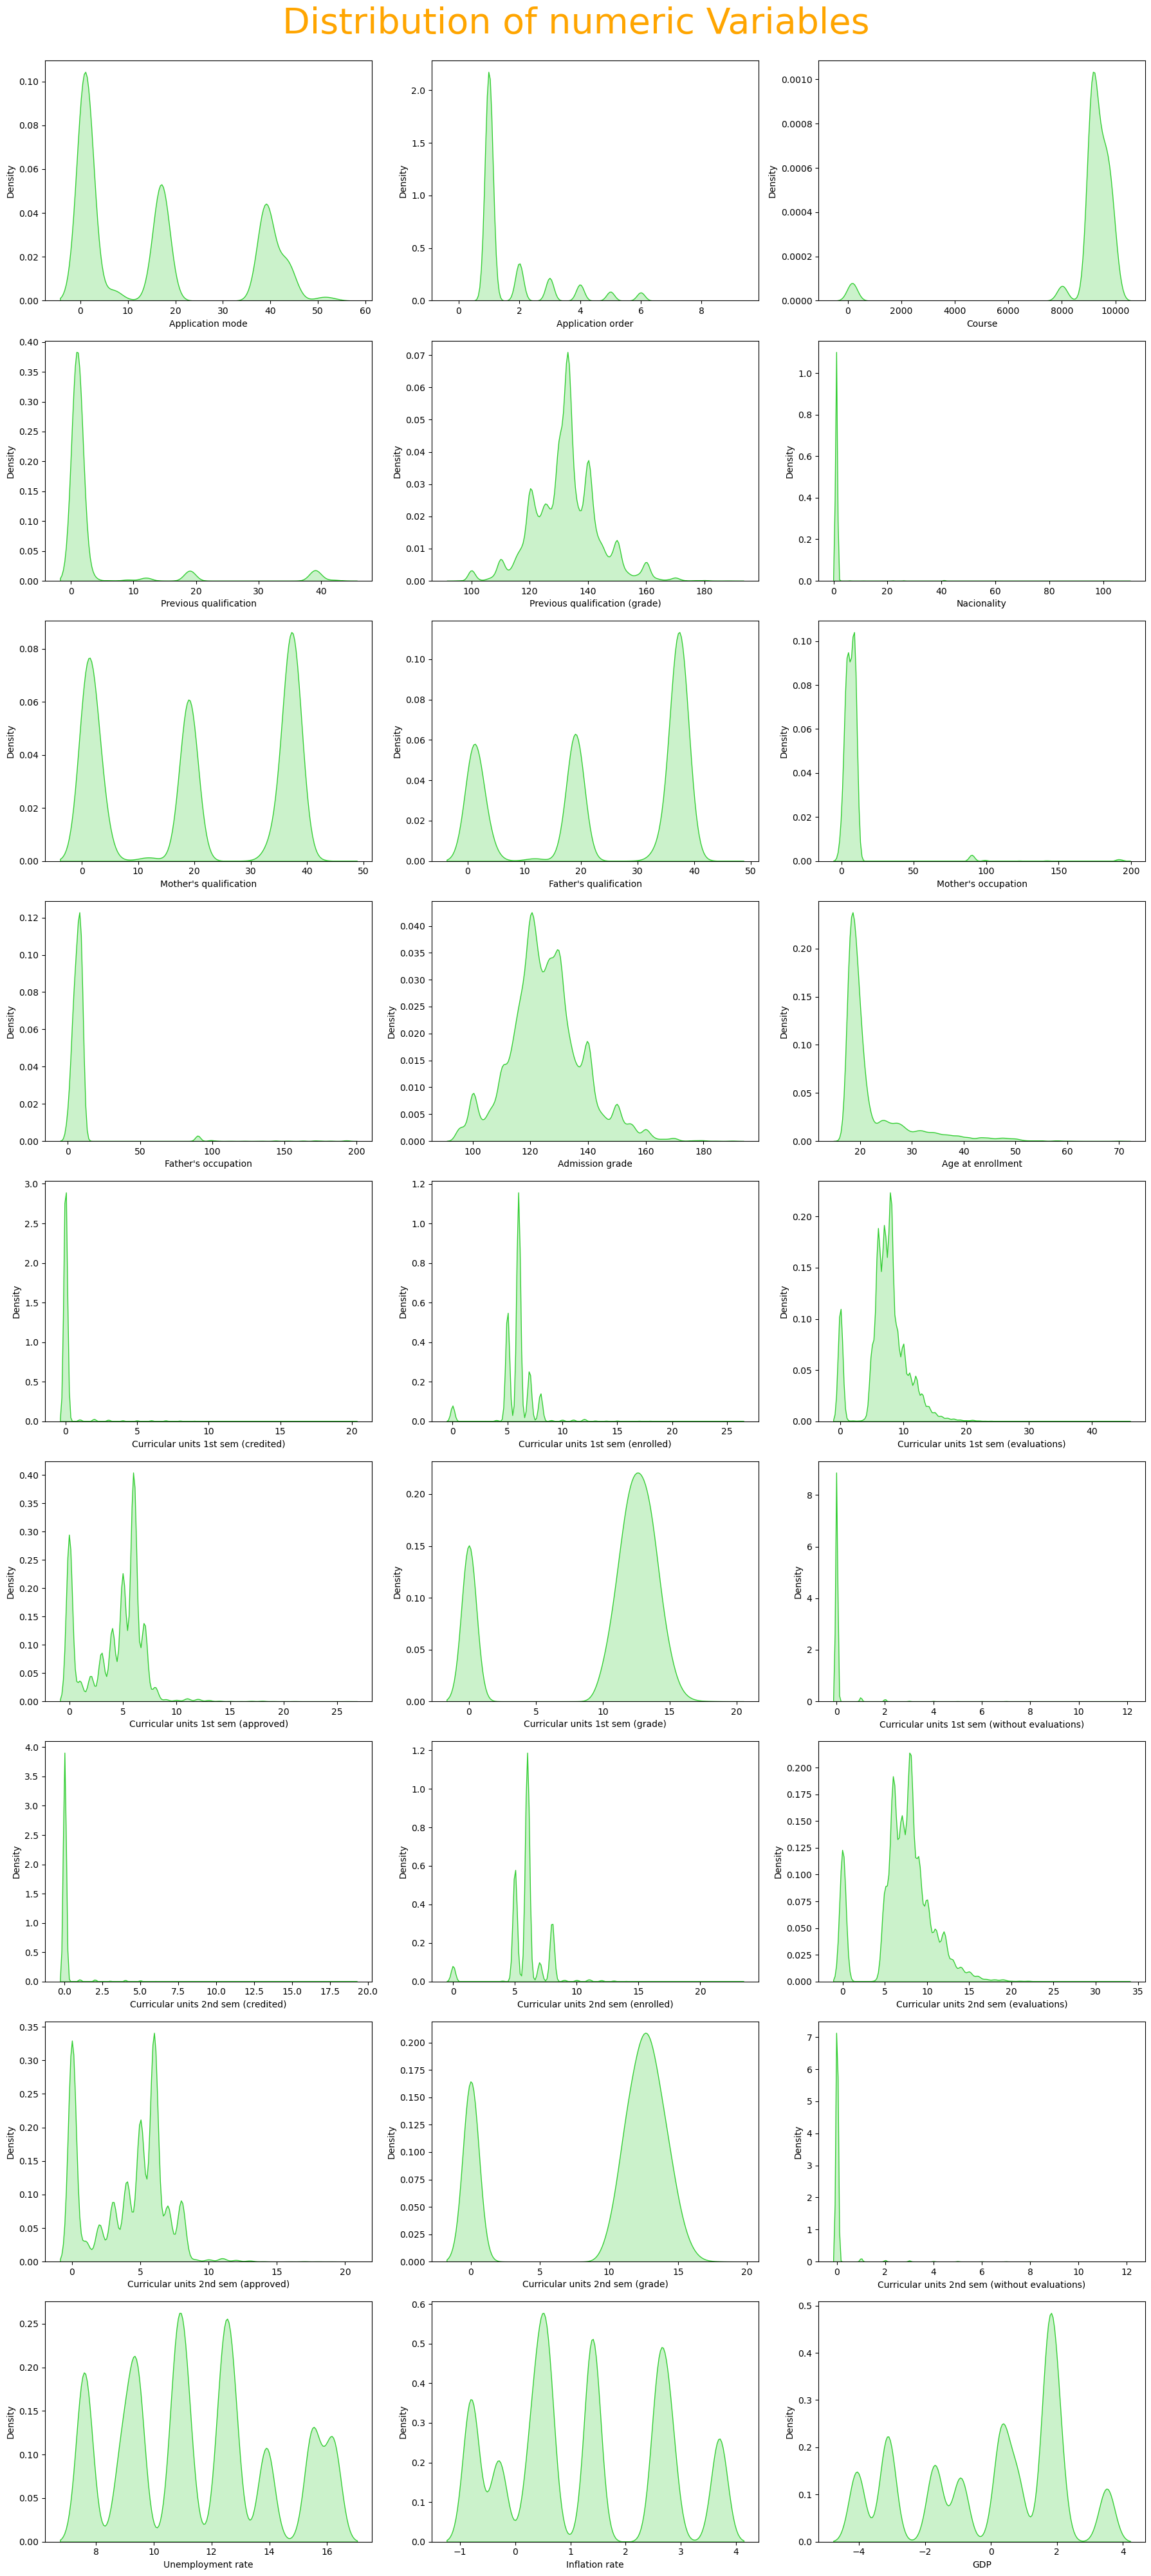

In [ ]:
#Density of Continious Variables
int_col=[column for column in train.columns if train[column].nunique()>7]
plt.figure(figsize=(18, 40))
num_col = 3
num_rows = (len(int_col) + num_col - 1) // num_col
for i, column in enumerate(int_col):
    plt.subplot(num_rows,num_col,i+1)
    sns.kdeplot(data=train, x=column, color='limegreen', fill=True)
plt.suptitle('Distribution of numeric Variables', fontsize=40, y=1,color='orange')
plt.tight_layout()
plt.show()

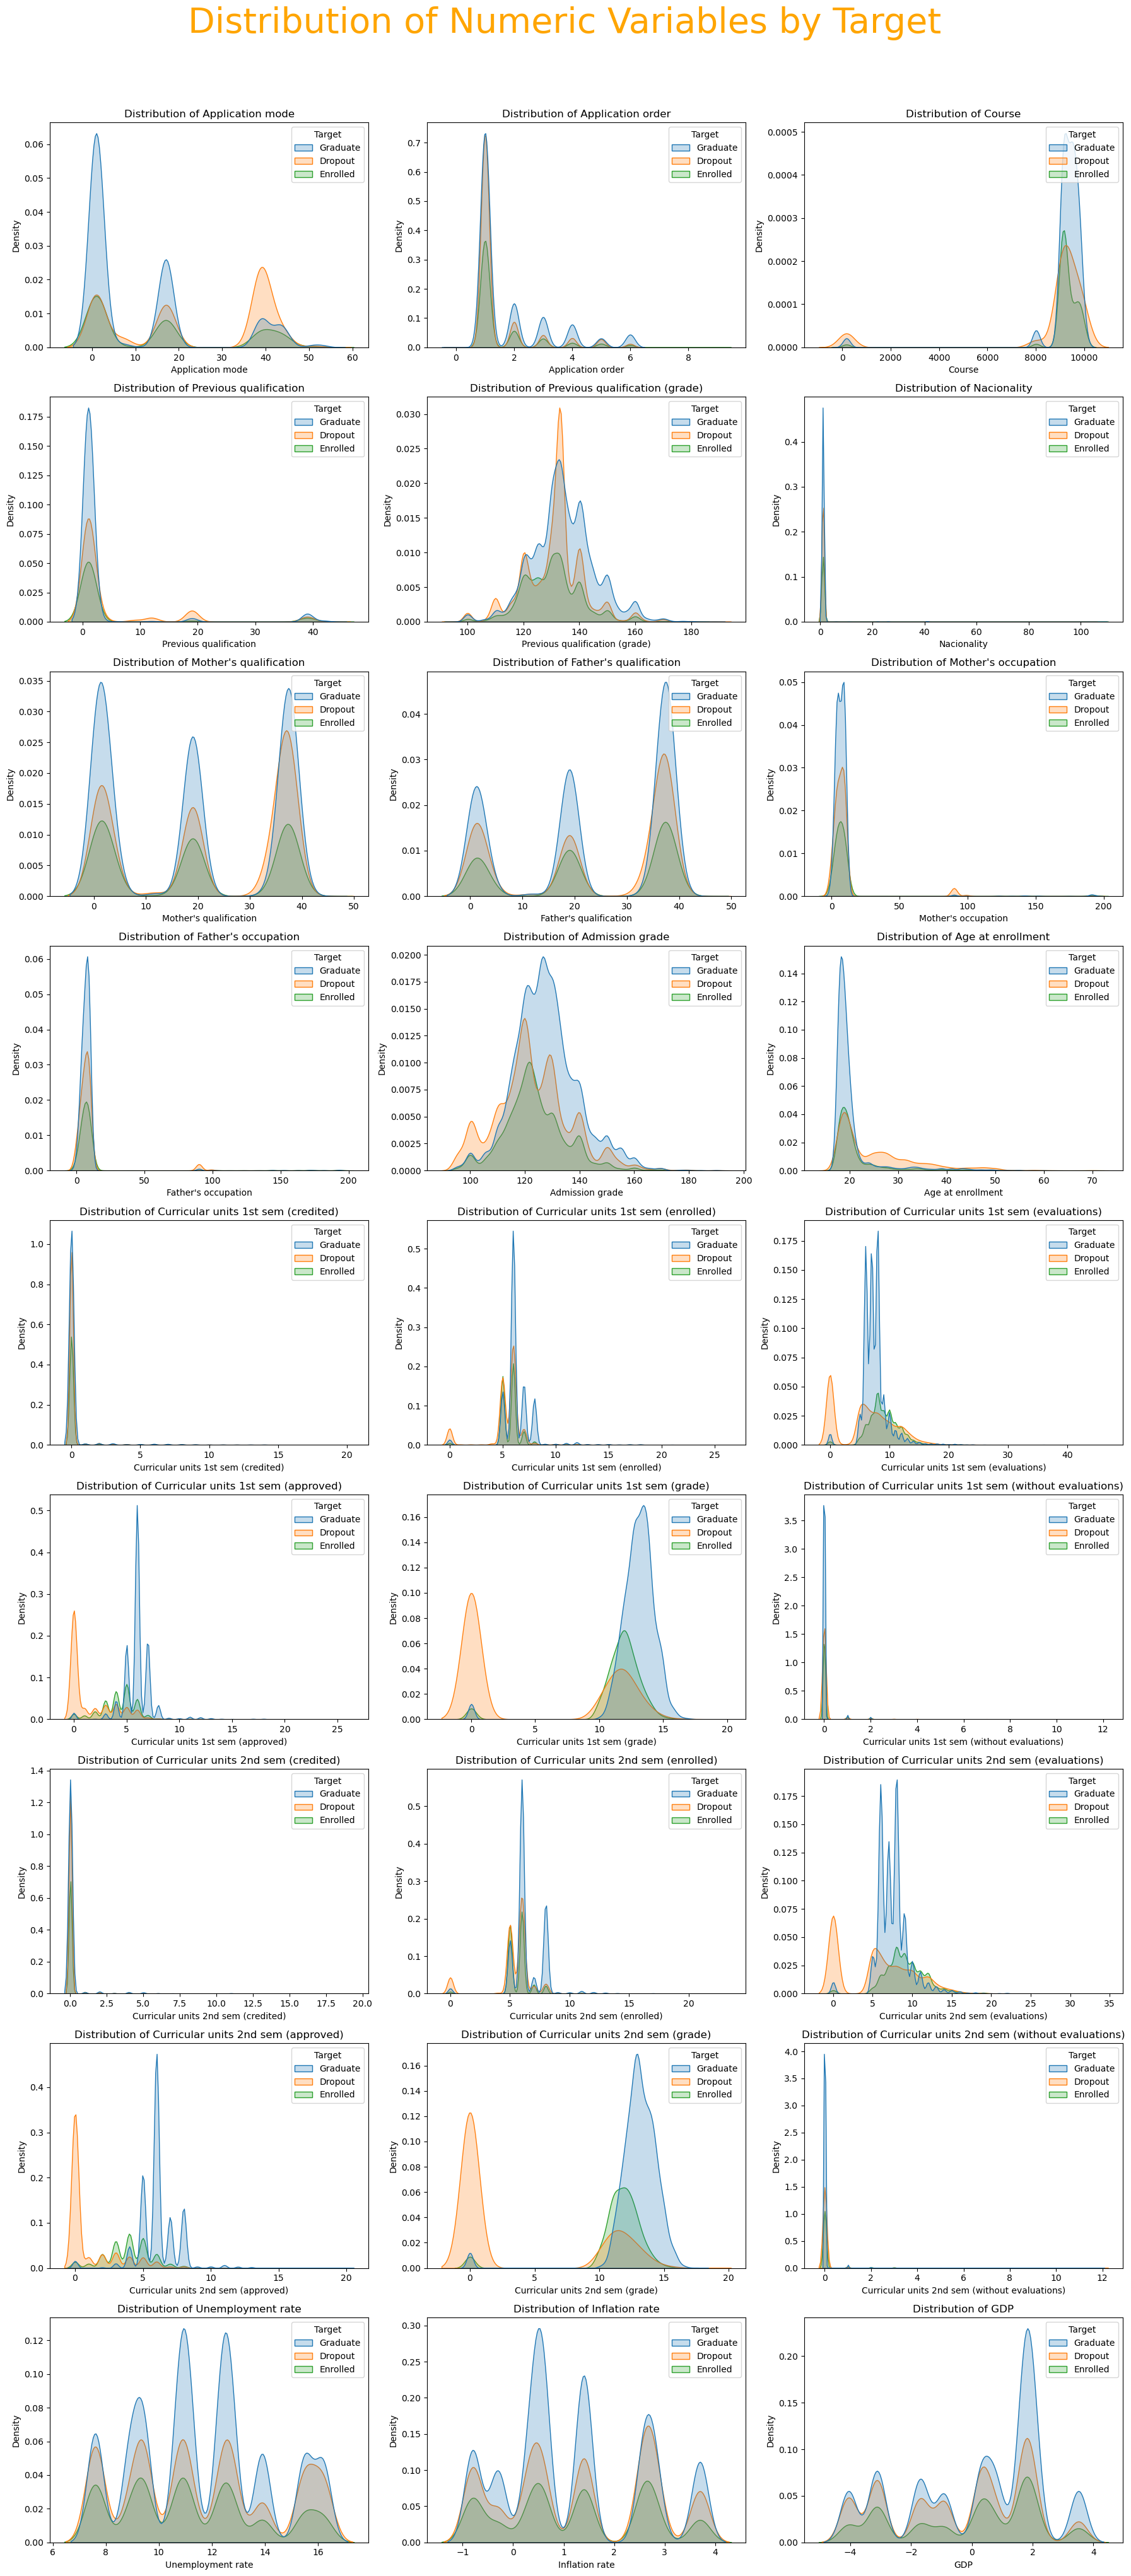

In [ ]:
#Density of Continous variables by target
int_col = [column for column in train.columns if train[column].nunique() > 7]

plt.figure(figsize=(18, 40))
num_col = 3
num_rows = (len(int_col) + num_col - 1) // num_col

for i, column in enumerate(int_col):
    plt.subplot(num_rows, num_col, i + 1)
    sns.kdeplot(data=train, x=column, hue='Target', fill=True)
    plt.title(f'Distribution of {column}')

plt.suptitle('Distribution of Numeric Variables by Target', fontsize=40, y=1.02, color='orange')
plt.tight_layout()
plt.show()

## Heatmap correlation

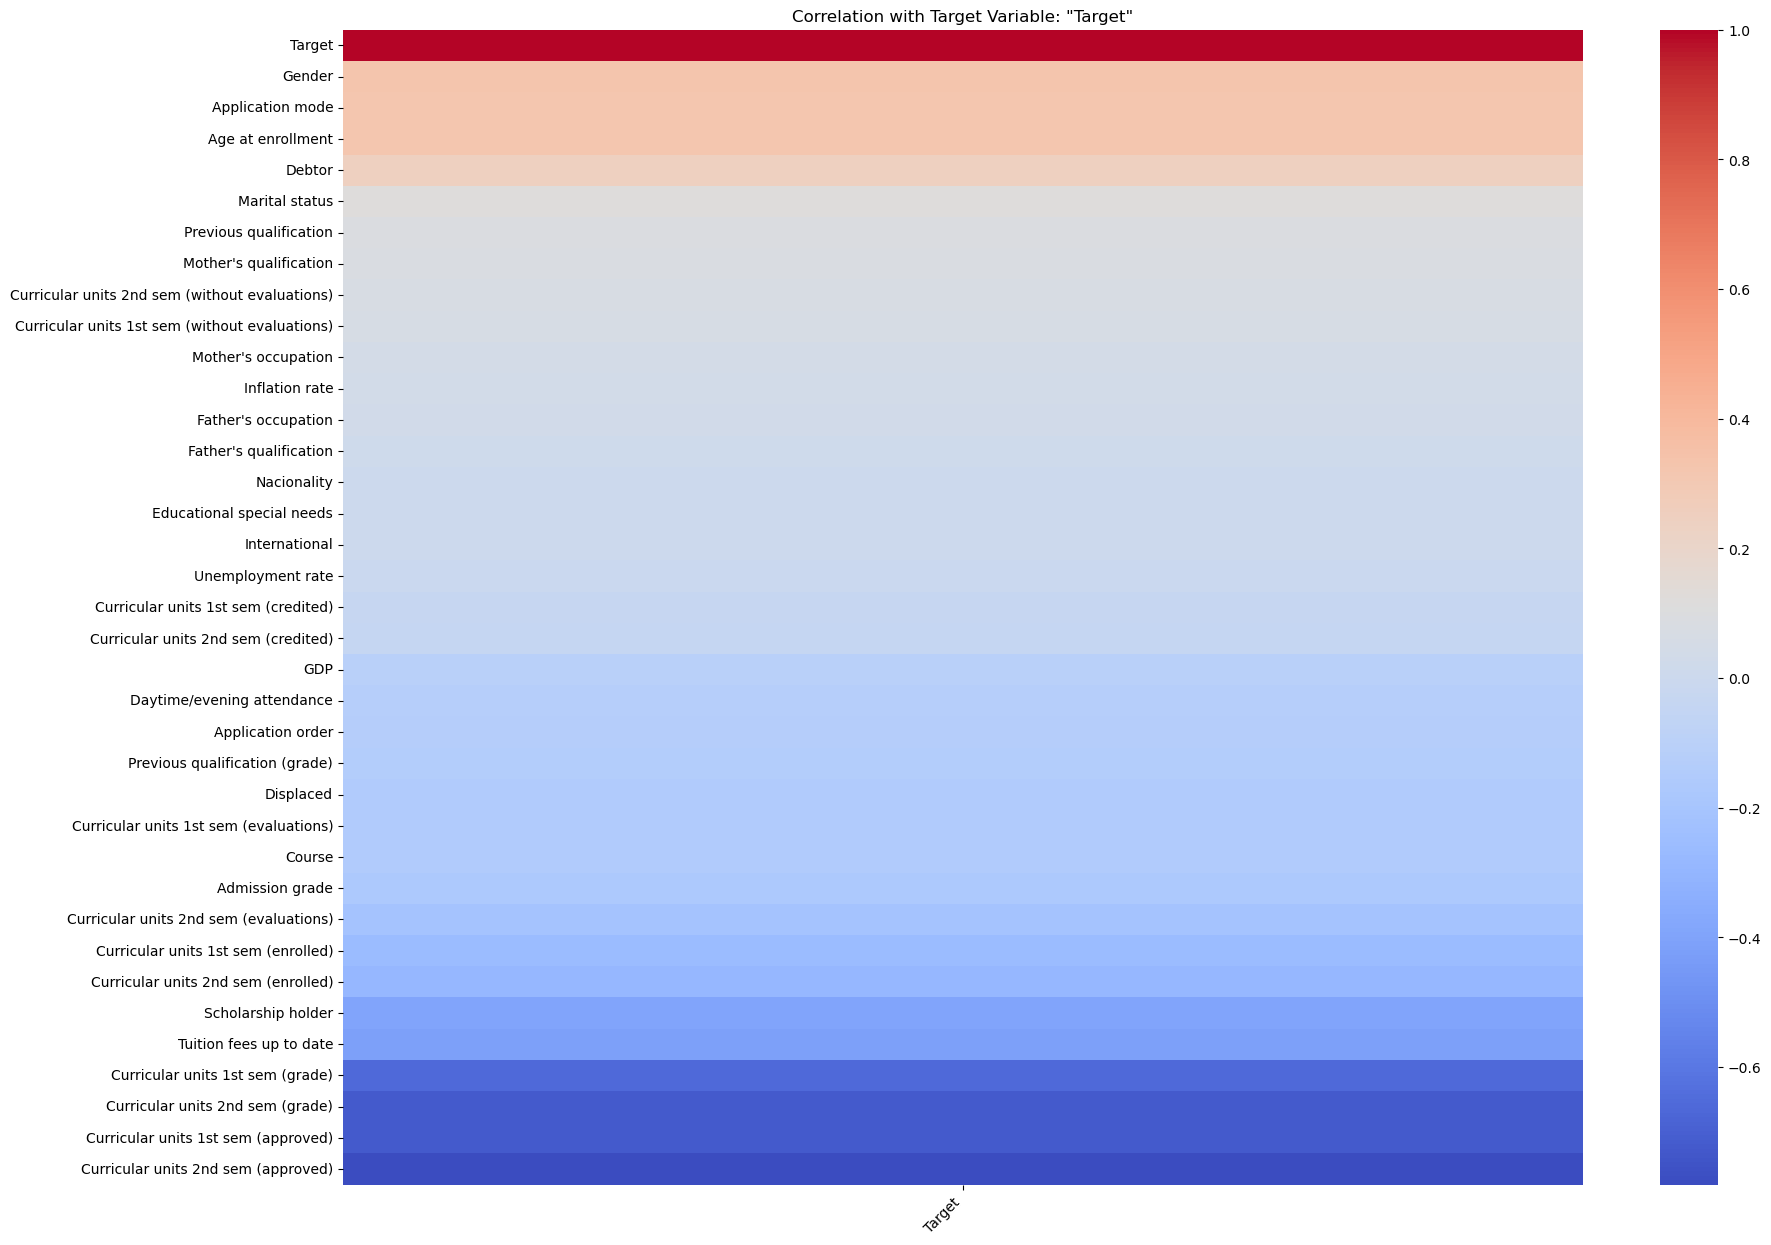

In [ ]:
#Columns correlation with target
tempdt= train.copy()
tempdt['Target']=tempdt.Target.apply(convert_to_int)
correlation_matrix = tempdt.corr()
plt.figure(figsize=(20, 15))
heatmap = sns.heatmap(correlation_matrix[['Target']].sort_values(by='Target', ascending=False), cmap='coolwarm')
plt.title(f'Correlation with Target Variable: "Target"')
plt.xticks(rotation=45, ha='right')
plt.show()

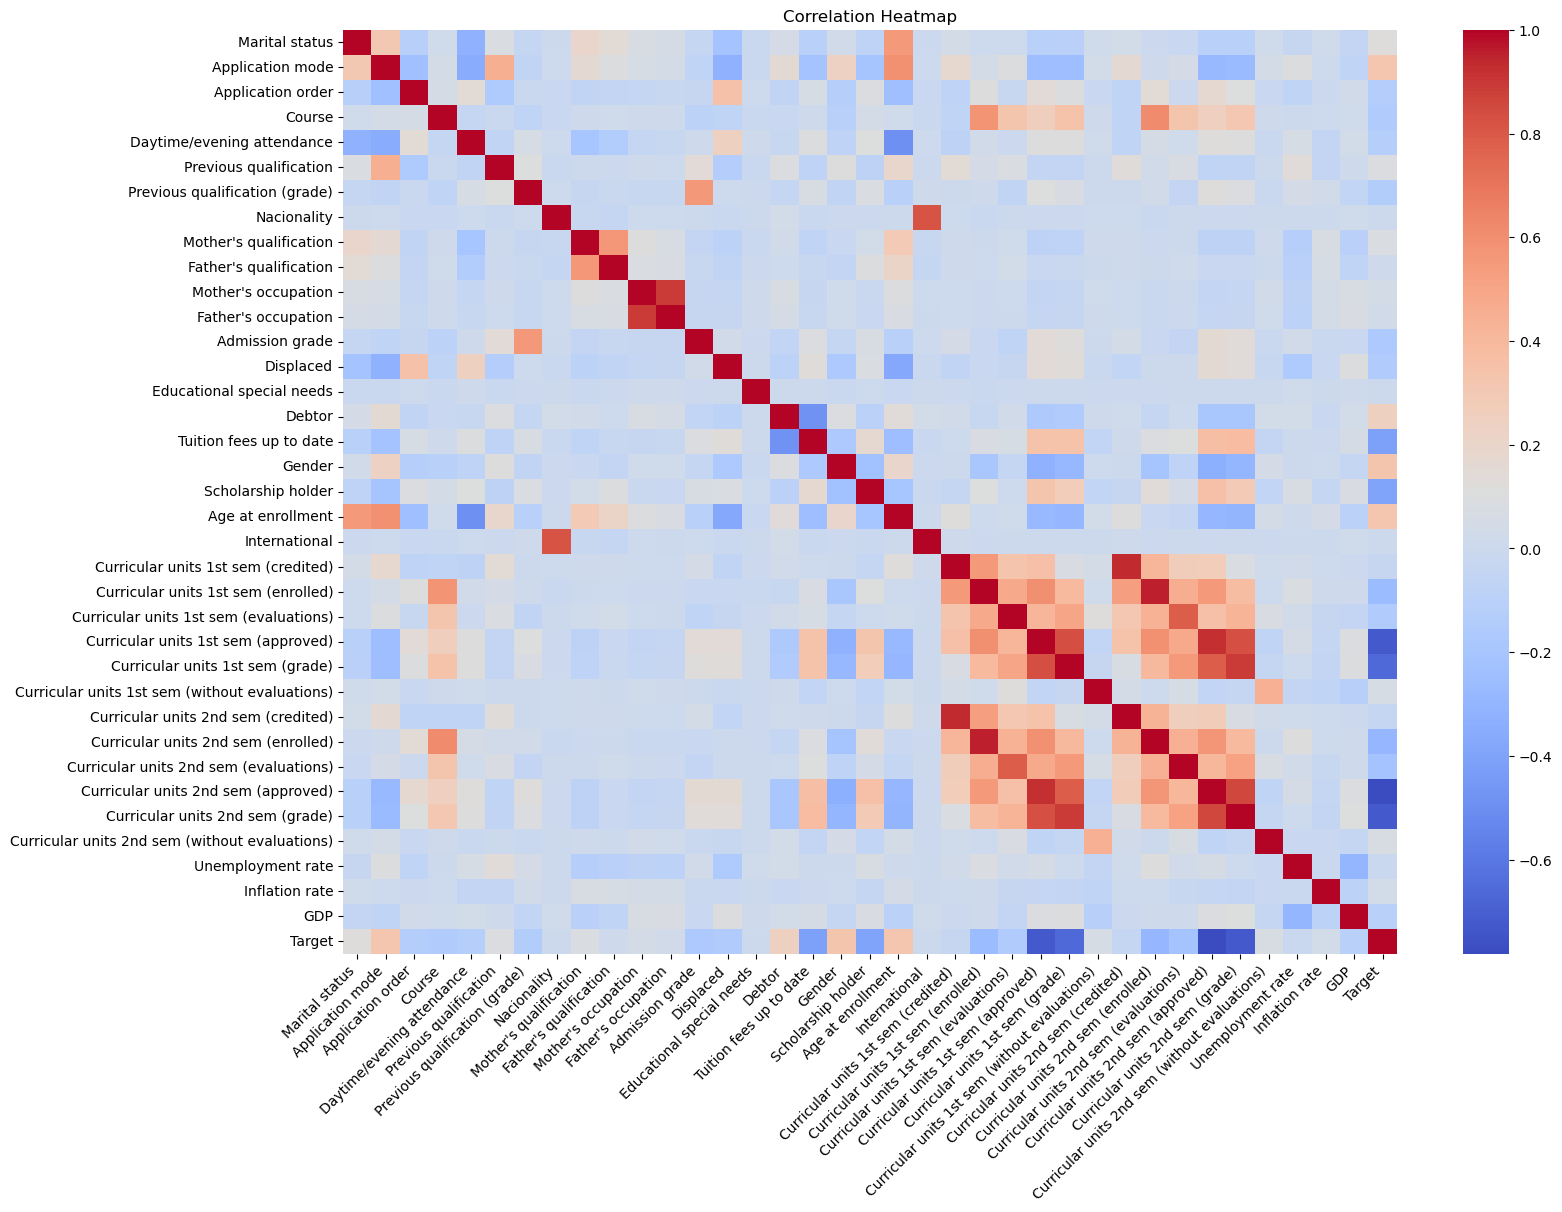

In [ ]:
#Heatmap Correlation Matrix
plt.figure(figsize=(17,12))
heatmap = sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.xticks(rotation=45, ha='right')
plt.yticks()
plt.title('Correlation Heatmap')
plt.show()

# Split the data

In [ ]:
# Creating function since needed multiple use
def Split(df):
    X = df.drop('Target', axis=1)
    y = df['Target']
    y = y.apply(convert_to_int)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, train_size=0.7, random_state=314159)
    return X,y,X_train, X_test, y_train, y_test


In [ ]:
X,y,X_train, X_test, y_train, y_test= Split(train)

# Feature & Preprocessing

In [ ]:
# For future experiments

# We tried many methods for feature engineering that didn't improve our scores:

#Grouping of related features (according to the heatmap)
#Increase weights of what we thougth are important features (e.g gender,scholarship ) logistic regression and KNN
#We experimented on Marital_status feature (1 or "other")
#we tried to split the data into 2 populations (Men&Women) and it also didn't improve our model.

# Models

## LogisticRegression - multi_class

In [ ]:
#27 in the k of SelectKBest because we saw on some of the models it chose this feature number
scaler = StandardScaler().set_output(transform='pandas')
selector = SelectKBest(k=30).set_output(transform='pandas')

pipeline = Pipeline([
    ('scaler', scaler),
    ('selector', selector),
    ('lg', LogisticRegression(max_iter=500, multi_class='ovr'))
])

param_grid = {
    'lg__C':  [10],
    'lg__penalty': ['l2'],
    'lg__solver': ['liblinear']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5,scoring='accuracy')
# Fit the model
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('selector', SelectKBest(k=30)),
                                       ('lg',
                                        LogisticRegression(max_iter=500,
                                                           multi_class='ovr'))]),
             param_grid={'lg__C': [10], 'lg__penalty': ['l2'],
                         'lg__solver': ['liblinear']},
             scoring='accuracy')

In [ ]:
# Print best parameters
print("Best parameters found: ", grid_search.best_params_)
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Best parameters found:  {'lg__C': 10, 'lg__penalty': 'l2', 'lg__solver': 'liblinear'}
Accuracy: 0.8130771911482837


In [ ]:
#Confusion matrix
cm = confusion_matrix(y_true=y_test,
                      y_pred=y_pred)
pd.DataFrame(cm,
             index=grid_search.classes_,
             columns=grid_search.classes_)

,1,2,3
1,10349,469,214
2,1716,2192,505
3,587,800,6124


In [ ]:
print(classification_report(y_true=y_test,
                            y_pred=y_pred))

              precision    recall  f1-score   support

           1       0.82      0.94      0.87     11032
           2       0.63      0.50      0.56      4413
           3       0.89      0.82      0.85      7511

    accuracy                           0.81     22956
   macro avg       0.78      0.75      0.76     22956
weighted avg       0.81      0.81      0.81     22956



## KNeighborsClassifier

In [ ]:
start = datetime.now()
print('start time',start)

pipeline = Pipeline([
    ('scaler', scaler),
    ('selector', selector),
    ('knn', KNeighborsClassifier())])


param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9],
    'knn__weights': ['uniform', 'distance'],
    'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'knn__leaf_size': [20, 30, 40, 50]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5,scoring='accuracy')
start = datetime.now()
print('start time',start)

grid_search.fit(X_train, y_train)

end = datetime.now()
print("Execution time: ",end - start)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")



end = datetime.now()
print("Execution time: ",end - start)


start time 2024-07-28 22:54:35.969645
start time 2024-07-28 22:54:35.969645
Execution time:  2:01:04.124433
Best Parameters: {'knn__algorithm': 'auto', 'knn__leaf_size': 20, 'knn__n_neighbors': 9, 'knn__weights': 'distance'}
Best Score: 0.7908404420529468
Execution time:  2:01:04.131734


In [ ]:
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy: ", accuracy)

Test set accuracy:  0.7956525527095313


## Random forest

In [ ]:
rf_clf = RandomForestClassifier(random_state=0,)


In [ ]:
my_param_grid = {
                 'n_estimators': [50, 100, 200, 300],
                 'max_depth': [3, 5, 7, 10],
                 'min_samples_split': [5,10]
                }


In [ ]:
rf_clf = GridSearchCV(rf_clf, my_param_grid, cv=5, scoring='accuracy')
start = datetime.now()
print('start time',start)
rf_clf.fit(X_train, y_train)
print(rf_clf.best_score_)
print(rf_clf.best_params_)
end = datetime.now()
print("Execution time: ",end - start)

start time 2024-07-29 00:55:43.206435
0.8229341474175806
{'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 300}
Execution time:  0:09:20.475586


In [ ]:
print(rf_clf.best_score_)
print(rf_clf.best_params_)
print(rf_clf.cv_results_)

0.8229341474175806
{'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 300}
{'mean_fit_time': array([0.61013422, 1.25398684, 2.34668498, 3.56506777, 0.61502328,
       1.15167937, 2.36084752, 3.49323592, 0.83784995, 1.84948087,
       3.43279657, 5.15224171, 0.83600731, 1.67999525, 3.45535245,
       5.01256599, 1.12844887, 2.24585605, 4.52622108, 6.73289652,
       1.11456847, 2.27093892, 4.36090202, 6.71839371, 1.55460358,
       3.13133173, 6.13813505, 9.05598798, 1.5147306 , 3.0466835 ,
       6.12458439, 9.11934175]), 'std_fit_time': array([0.05074308, 0.16860753, 0.08223259, 0.14282408, 0.05940131,
       0.01674806, 0.18502325, 0.13975178, 0.01284598, 0.13248253,
       0.17278105, 0.22804425, 0.01096513, 0.02588764, 0.23510804,
       0.13133816, 0.07896043, 0.07906569, 0.18708787, 0.20381112,
       0.04627993, 0.1483399 , 0.11351628, 0.12947088, 0.10962819,
       0.25609309, 0.3082816 , 0.23484878, 0.05267679, 0.19216833,
       0.22778801, 0.30268178]), 'mean_score_ti

## Boosting models

### XGBoost

In [ ]:
# Ensure labels are within [0, num_class-1]
num_class = len(np.unique(y))
y_xgb = y % num_class  # Ensure that labels are in the range [0, num_class-1]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_xgb, test_size=0.2, random_state=314159)

# Define the scaler
scaler = StandardScaler()

# Fit and transform the training data, transform the test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to XGBoost DMatrix
dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)

def objective(trial):
    # Define hyperparameters to tune
    params = {
        'objective': 'multi:softmax',
        'num_class': len(np.unique(y_xgb)),
        'eval_metric': 'mlogloss',
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_float('lambda', 0.0, 5.0),  # L2 regularization
        'alpha': trial.suggest_float('alpha', 0.0, 5.0)     # L1 regularization
    }

    # Train the model
    bst = xgb.train(params, dtrain, evals=[(dtest, 'test')], num_boost_round=100, early_stopping_rounds=10)

    # Make predictions and calculate accuracy
    y_pred = bst.predict(dtest)
    accuracy = np.mean(y_pred == y_test)

    return accuracy

# Create Optuna study and optimize
start = datetime.now()
print('start time',start)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
# Print the best parameters and best accuracy
print("Best parameters:", study.best_params)
print("Best accuracy:", study.best_value)


best_params = study.best_params
best_params['objective'] = 'multi:softmax'
best_params['num_class'] = num_class
best_params['eval_metric'] = 'mlogloss'

# Train the final model with the best parameters
final_model = xgb.train(best_params, dtrain, num_boost_round=100)

# Make predictions on real test data from kaggle
y_pred_test = final_model.predict(xgb.DMatrix(real_test))
end = datetime.now()
print("Execution time: ",end - start)

[I 2024-07-29 01:05:04,070] A new study created in memory with name: no-name-1dfd8113-d2b6-403b-8116-63693445d5a0


start time 2024-07-29 01:05:04.063093
[0]	test-mlogloss:0.99511
[1]	test-mlogloss:0.90934
[2]	test-mlogloss:0.84041
[3]	test-mlogloss:0.78276
[4]	test-mlogloss:0.73441
[5]	test-mlogloss:0.69445
[6]	test-mlogloss:0.66010
[7]	test-mlogloss:0.63114
[8]	test-mlogloss:0.60608
[9]	test-mlogloss:0.58479
[10]	test-mlogloss:0.56718
[11]	test-mlogloss:0.55141
[12]	test-mlogloss:0.53779
[13]	test-mlogloss:0.52636
[14]	test-mlogloss:0.51626
[15]	test-mlogloss:0.50760
[16]	test-mlogloss:0.49984
[17]	test-mlogloss:0.49336
[18]	test-mlogloss:0.48789
[19]	test-mlogloss:0.48295
[20]	test-mlogloss:0.47857
[21]	test-mlogloss:0.47457
[22]	test-mlogloss:0.47116
[23]	test-mlogloss:0.46833
[24]	test-mlogloss:0.46567
[25]	test-mlogloss:0.46334
[26]	test-mlogloss:0.46134
[27]	test-mlogloss:0.45952
[28]	test-mlogloss:0.45799
[29]	test-mlogloss:0.45642
[30]	test-mlogloss:0.45518
[31]	test-mlogloss:0.45391
[32]	test-mlogloss:0.45266
[33]	test-mlogloss:0.45156
[34]	test-mlogloss:0.45060
[35]	test-mlogloss:0.45003


[I 2024-07-29 01:05:08,754] Trial 0 finished with value: 0.8303058024046001 and parameters: {'eta': 0.1254344055939834, 'max_depth': 11, 'subsample': 0.8964895221854494, 'colsample_bytree': 0.8177735216263494, 'lambda': 4.298590097851299, 'alpha': 3.9678878145025918}. Best is trial 0 with value: 0.8303058024046001.


[0]	test-mlogloss:1.05287
[1]	test-mlogloss:1.00847
[2]	test-mlogloss:0.96744
[3]	test-mlogloss:0.93112
[4]	test-mlogloss:0.89667
[5]	test-mlogloss:0.86662
[6]	test-mlogloss:0.83776
[7]	test-mlogloss:0.81211
[8]	test-mlogloss:0.78844
[9]	test-mlogloss:0.76622
[10]	test-mlogloss:0.74651
[11]	test-mlogloss:0.72788
[12]	test-mlogloss:0.71026
[13]	test-mlogloss:0.69426
[14]	test-mlogloss:0.67905
[15]	test-mlogloss:0.66534
[16]	test-mlogloss:0.65202
[17]	test-mlogloss:0.64040
[18]	test-mlogloss:0.62972
[19]	test-mlogloss:0.61883
[20]	test-mlogloss:0.60890
[21]	test-mlogloss:0.59948
[22]	test-mlogloss:0.59069
[23]	test-mlogloss:0.58293
[24]	test-mlogloss:0.57524
[25]	test-mlogloss:0.56788
[26]	test-mlogloss:0.56117
[27]	test-mlogloss:0.55506
[28]	test-mlogloss:0.54939
[29]	test-mlogloss:0.54439
[30]	test-mlogloss:0.53966
[31]	test-mlogloss:0.53473
[32]	test-mlogloss:0.52999
[33]	test-mlogloss:0.52572
[34]	test-mlogloss:0.52183
[35]	test-mlogloss:0.51826
[36]	test-mlogloss:0.51507
[37]	test-m

[I 2024-07-29 01:05:11,693] Trial 1 finished with value: 0.823379508625196 and parameters: {'eta': 0.0596307233884087, 'max_depth': 5, 'subsample': 0.9438919404116732, 'colsample_bytree': 0.5547748669803765, 'lambda': 1.5393668883674398, 'alpha': 2.9166129534288707}. Best is trial 0 with value: 0.8303058024046001.


[0]	test-mlogloss:1.07422
[1]	test-mlogloss:1.04954
[2]	test-mlogloss:1.02631
[3]	test-mlogloss:1.00391
[4]	test-mlogloss:0.98253
[5]	test-mlogloss:0.96227
[6]	test-mlogloss:0.94300
[7]	test-mlogloss:0.92457
[8]	test-mlogloss:0.90700
[9]	test-mlogloss:0.89012
[10]	test-mlogloss:0.87457
[11]	test-mlogloss:0.85906
[12]	test-mlogloss:0.84428
[13]	test-mlogloss:0.83035
[14]	test-mlogloss:0.81684
[15]	test-mlogloss:0.80406
[16]	test-mlogloss:0.79135
[17]	test-mlogloss:0.77926
[18]	test-mlogloss:0.76791
[19]	test-mlogloss:0.75674
[20]	test-mlogloss:0.74613
[21]	test-mlogloss:0.73582
[22]	test-mlogloss:0.72593
[23]	test-mlogloss:0.71691
[24]	test-mlogloss:0.70781
[25]	test-mlogloss:0.69899
[26]	test-mlogloss:0.69043
[27]	test-mlogloss:0.68222
[28]	test-mlogloss:0.67468
[29]	test-mlogloss:0.66720
[30]	test-mlogloss:0.66030
[31]	test-mlogloss:0.65315
[32]	test-mlogloss:0.64627
[33]	test-mlogloss:0.63968
[34]	test-mlogloss:0.63344
[35]	test-mlogloss:0.62763
[36]	test-mlogloss:0.62197
[37]	test-m

[I 2024-07-29 01:05:15,525] Trial 2 finished with value: 0.8230527966544694 and parameters: {'eta': 0.02986125667623067, 'max_depth': 7, 'subsample': 0.7500201968071197, 'colsample_bytree': 0.7419712961939369, 'lambda': 0.5018665869244215, 'alpha': 3.435172423980728}. Best is trial 0 with value: 0.8303058024046001.


[0]	test-mlogloss:1.08234
[1]	test-mlogloss:1.06608
[2]	test-mlogloss:1.05056
[3]	test-mlogloss:1.03548
[4]	test-mlogloss:1.02083
[5]	test-mlogloss:1.00665
[6]	test-mlogloss:0.99279
[7]	test-mlogloss:0.97954
[8]	test-mlogloss:0.96648
[9]	test-mlogloss:0.95390
[10]	test-mlogloss:0.94196
[11]	test-mlogloss:0.93001
[12]	test-mlogloss:0.91842
[13]	test-mlogloss:0.90735
[14]	test-mlogloss:0.89656
[15]	test-mlogloss:0.88600
[16]	test-mlogloss:0.87566
[17]	test-mlogloss:0.86558
[18]	test-mlogloss:0.85593
[19]	test-mlogloss:0.84645
[20]	test-mlogloss:0.83715
[21]	test-mlogloss:0.82816
[22]	test-mlogloss:0.81940
[23]	test-mlogloss:0.81097
[24]	test-mlogloss:0.80276
[25]	test-mlogloss:0.79475
[26]	test-mlogloss:0.78680
[27]	test-mlogloss:0.77919
[28]	test-mlogloss:0.77179
[29]	test-mlogloss:0.76445
[30]	test-mlogloss:0.75727
[31]	test-mlogloss:0.75031
[32]	test-mlogloss:0.74350
[33]	test-mlogloss:0.73685
[34]	test-mlogloss:0.73043
[35]	test-mlogloss:0.72415
[36]	test-mlogloss:0.71810
[37]	test-m

[I 2024-07-29 01:05:19,190] Trial 3 finished with value: 0.8222033455305803 and parameters: {'eta': 0.018846070763372438, 'max_depth': 9, 'subsample': 0.732947576755131, 'colsample_bytree': 0.866885231781553, 'lambda': 2.111088616511887, 'alpha': 3.2424176530896407}. Best is trial 0 with value: 0.8303058024046001.


[0]	test-mlogloss:0.90430
[1]	test-mlogloss:0.77494
[2]	test-mlogloss:0.69193
[3]	test-mlogloss:0.63484
[4]	test-mlogloss:0.59303
[5]	test-mlogloss:0.56449
[6]	test-mlogloss:0.54265
[7]	test-mlogloss:0.52700
[8]	test-mlogloss:0.51479
[9]	test-mlogloss:0.50565
[10]	test-mlogloss:0.49829
[11]	test-mlogloss:0.49302
[12]	test-mlogloss:0.48787
[13]	test-mlogloss:0.48403
[14]	test-mlogloss:0.48095
[15]	test-mlogloss:0.47779
[16]	test-mlogloss:0.47503
[17]	test-mlogloss:0.47314
[18]	test-mlogloss:0.47094
[19]	test-mlogloss:0.46914
[20]	test-mlogloss:0.46711
[21]	test-mlogloss:0.46508
[22]	test-mlogloss:0.46361
[23]	test-mlogloss:0.46257
[24]	test-mlogloss:0.46173
[25]	test-mlogloss:0.46085
[26]	test-mlogloss:0.45979
[27]	test-mlogloss:0.45861
[28]	test-mlogloss:0.45785
[29]	test-mlogloss:0.45708
[30]	test-mlogloss:0.45640
[31]	test-mlogloss:0.45586
[32]	test-mlogloss:0.45523
[33]	test-mlogloss:0.45474
[34]	test-mlogloss:0.45406
[35]	test-mlogloss:0.45365
[36]	test-mlogloss:0.45318
[37]	test-m

[I 2024-07-29 01:05:21,041] Trial 4 finished with value: 0.8285415577626765 and parameters: {'eta': 0.2789750499094325, 'max_depth': 3, 'subsample': 0.9045786827243465, 'colsample_bytree': 0.8335006114563104, 'lambda': 4.089958186913706, 'alpha': 0.6444608133589391}. Best is trial 0 with value: 0.8303058024046001.


[0]	test-mlogloss:1.07970
[1]	test-mlogloss:1.06023
[2]	test-mlogloss:1.04113
[3]	test-mlogloss:1.02336
[4]	test-mlogloss:1.00568
[5]	test-mlogloss:0.98936
[6]	test-mlogloss:0.97303
[7]	test-mlogloss:0.95762
[8]	test-mlogloss:0.94297
[9]	test-mlogloss:0.92846
[10]	test-mlogloss:0.91507
[11]	test-mlogloss:0.90196
[12]	test-mlogloss:0.88890
[13]	test-mlogloss:0.87668
[14]	test-mlogloss:0.86463
[15]	test-mlogloss:0.85323
[16]	test-mlogloss:0.84183
[17]	test-mlogloss:0.83141
[18]	test-mlogloss:0.82136
[19]	test-mlogloss:0.81087
[20]	test-mlogloss:0.80097
[21]	test-mlogloss:0.79139
[22]	test-mlogloss:0.78196
[23]	test-mlogloss:0.77345
[24]	test-mlogloss:0.76464
[25]	test-mlogloss:0.75604
[26]	test-mlogloss:0.74771
[27]	test-mlogloss:0.73973
[28]	test-mlogloss:0.73223
[29]	test-mlogloss:0.72530
[30]	test-mlogloss:0.71851
[31]	test-mlogloss:0.71129
[32]	test-mlogloss:0.70428
[33]	test-mlogloss:0.69752
[34]	test-mlogloss:0.69104
[35]	test-mlogloss:0.68503
[36]	test-mlogloss:0.67933
[37]	test-m

[I 2024-07-29 01:05:23,163] Trial 5 finished with value: 0.8173026659696812 and parameters: {'eta': 0.02437222262853482, 'max_depth': 5, 'subsample': 0.9644339381918098, 'colsample_bytree': 0.560431710511635, 'lambda': 1.4418817220963502, 'alpha': 4.693691162087882}. Best is trial 0 with value: 0.8303058024046001.


[0]	test-mlogloss:0.87406
[1]	test-mlogloss:0.73623
[2]	test-mlogloss:0.64837
[3]	test-mlogloss:0.58902
[4]	test-mlogloss:0.54793
[5]	test-mlogloss:0.51977
[6]	test-mlogloss:0.50013
[7]	test-mlogloss:0.48678
[8]	test-mlogloss:0.47606
[9]	test-mlogloss:0.46849
[10]	test-mlogloss:0.46340
[11]	test-mlogloss:0.45967
[12]	test-mlogloss:0.45662
[13]	test-mlogloss:0.45437
[14]	test-mlogloss:0.45276
[15]	test-mlogloss:0.45168
[16]	test-mlogloss:0.45071
[17]	test-mlogloss:0.45044
[18]	test-mlogloss:0.44993
[19]	test-mlogloss:0.44903
[20]	test-mlogloss:0.44888
[21]	test-mlogloss:0.44862
[22]	test-mlogloss:0.44870
[23]	test-mlogloss:0.44844
[24]	test-mlogloss:0.44861
[25]	test-mlogloss:0.44891
[26]	test-mlogloss:0.44892
[27]	test-mlogloss:0.44884
[28]	test-mlogloss:0.44871
[29]	test-mlogloss:0.44913
[30]	test-mlogloss:0.44884
[31]	test-mlogloss:0.44914
[32]	test-mlogloss:0.44914
[33]	test-mlogloss:0.44945


[I 2024-07-29 01:05:24,675] Trial 6 finished with value: 0.8271693674856246 and parameters: {'eta': 0.28441718916696196, 'max_depth': 10, 'subsample': 0.8901501647940462, 'colsample_bytree': 0.9378027781430947, 'lambda': 0.684087038774504, 'alpha': 0.9178652552630845}. Best is trial 0 with value: 0.8303058024046001.


[0]	test-mlogloss:0.88045
[1]	test-mlogloss:0.74373
[2]	test-mlogloss:0.65869
[3]	test-mlogloss:0.60046
[4]	test-mlogloss:0.56073
[5]	test-mlogloss:0.53328
[6]	test-mlogloss:0.51377
[7]	test-mlogloss:0.49975
[8]	test-mlogloss:0.48936
[9]	test-mlogloss:0.48185
[10]	test-mlogloss:0.47643
[11]	test-mlogloss:0.47178
[12]	test-mlogloss:0.46774
[13]	test-mlogloss:0.46469
[14]	test-mlogloss:0.46196
[15]	test-mlogloss:0.45978
[16]	test-mlogloss:0.45788
[17]	test-mlogloss:0.45675
[18]	test-mlogloss:0.45537
[19]	test-mlogloss:0.45392
[20]	test-mlogloss:0.45297
[21]	test-mlogloss:0.45161
[22]	test-mlogloss:0.45068
[23]	test-mlogloss:0.44984
[24]	test-mlogloss:0.44923
[25]	test-mlogloss:0.44879
[26]	test-mlogloss:0.44822
[27]	test-mlogloss:0.44767
[28]	test-mlogloss:0.44713
[29]	test-mlogloss:0.44670
[30]	test-mlogloss:0.44620
[31]	test-mlogloss:0.44568
[32]	test-mlogloss:0.44537
[33]	test-mlogloss:0.44484
[34]	test-mlogloss:0.44455
[35]	test-mlogloss:0.44416
[36]	test-mlogloss:0.44374
[37]	test-m

[I 2024-07-29 01:05:27,329] Trial 7 finished with value: 0.830893883951908 and parameters: {'eta': 0.2959332343789216, 'max_depth': 5, 'subsample': 0.633665931037391, 'colsample_bytree': 0.7909812754693863, 'lambda': 0.34872893862577303, 'alpha': 4.664925317920277}. Best is trial 7 with value: 0.830893883951908.


[0]	test-mlogloss:0.90181
[1]	test-mlogloss:0.77161
[2]	test-mlogloss:0.68496
[3]	test-mlogloss:0.62264
[4]	test-mlogloss:0.57776
[5]	test-mlogloss:0.54615
[6]	test-mlogloss:0.52228
[7]	test-mlogloss:0.50482
[8]	test-mlogloss:0.49161
[9]	test-mlogloss:0.48160
[10]	test-mlogloss:0.47460
[11]	test-mlogloss:0.46871
[12]	test-mlogloss:0.46422
[13]	test-mlogloss:0.46094
[14]	test-mlogloss:0.45803
[15]	test-mlogloss:0.45595
[16]	test-mlogloss:0.45376
[17]	test-mlogloss:0.45180
[18]	test-mlogloss:0.45076
[19]	test-mlogloss:0.44968
[20]	test-mlogloss:0.44899
[21]	test-mlogloss:0.44790
[22]	test-mlogloss:0.44729
[23]	test-mlogloss:0.44670
[24]	test-mlogloss:0.44650
[25]	test-mlogloss:0.44594
[26]	test-mlogloss:0.44564
[27]	test-mlogloss:0.44543
[28]	test-mlogloss:0.44501
[29]	test-mlogloss:0.44511
[30]	test-mlogloss:0.44504
[31]	test-mlogloss:0.44510
[32]	test-mlogloss:0.44510
[33]	test-mlogloss:0.44516
[34]	test-mlogloss:0.44484
[35]	test-mlogloss:0.44498
[36]	test-mlogloss:0.44493
[37]	test-m

[I 2024-07-29 01:05:29,349] Trial 8 finished with value: 0.8264506011500261 and parameters: {'eta': 0.2517801168590659, 'max_depth': 9, 'subsample': 0.6388497193518137, 'colsample_bytree': 0.7855535632739667, 'lambda': 2.859105962447412, 'alpha': 2.304909995751798}. Best is trial 7 with value: 0.830893883951908.


[0]	test-mlogloss:0.99098
[1]	test-mlogloss:0.90132
[2]	test-mlogloss:0.82808
[3]	test-mlogloss:0.76921
[4]	test-mlogloss:0.71867
[5]	test-mlogloss:0.67894
[6]	test-mlogloss:0.64464
[7]	test-mlogloss:0.61681
[8]	test-mlogloss:0.59263
[9]	test-mlogloss:0.57261
[10]	test-mlogloss:0.55627
[11]	test-mlogloss:0.54154
[12]	test-mlogloss:0.52856
[13]	test-mlogloss:0.51788
[14]	test-mlogloss:0.50850
[15]	test-mlogloss:0.50070
[16]	test-mlogloss:0.49354
[17]	test-mlogloss:0.48776
[18]	test-mlogloss:0.48287
[19]	test-mlogloss:0.47833
[20]	test-mlogloss:0.47450
[21]	test-mlogloss:0.47092
[22]	test-mlogloss:0.46788
[23]	test-mlogloss:0.46520
[24]	test-mlogloss:0.46265
[25]	test-mlogloss:0.46050
[26]	test-mlogloss:0.45868
[27]	test-mlogloss:0.45690
[28]	test-mlogloss:0.45545
[29]	test-mlogloss:0.45434
[30]	test-mlogloss:0.45320
[31]	test-mlogloss:0.45216
[32]	test-mlogloss:0.45119
[33]	test-mlogloss:0.45026
[34]	test-mlogloss:0.44931
[35]	test-mlogloss:0.44855
[36]	test-mlogloss:0.44778
[37]	test-m

[I 2024-07-29 01:05:33,473] Trial 9 finished with value: 0.8294563512807109 and parameters: {'eta': 0.13909273459266924, 'max_depth': 10, 'subsample': 0.8392099386213144, 'colsample_bytree': 0.5343942918437141, 'lambda': 2.6106246654122662, 'alpha': 3.946587616438566}. Best is trial 7 with value: 0.830893883951908.


[0]	test-mlogloss:0.95081
[1]	test-mlogloss:0.83451
[2]	test-mlogloss:0.75212
[3]	test-mlogloss:0.69072
[4]	test-mlogloss:0.64443
[5]	test-mlogloss:0.60946
[6]	test-mlogloss:0.58237
[7]	test-mlogloss:0.56146
[8]	test-mlogloss:0.54451
[9]	test-mlogloss:0.53153
[10]	test-mlogloss:0.52142
[11]	test-mlogloss:0.51344
[12]	test-mlogloss:0.50641
[13]	test-mlogloss:0.50100
[14]	test-mlogloss:0.49610
[15]	test-mlogloss:0.49229
[16]	test-mlogloss:0.48854
[17]	test-mlogloss:0.48565
[18]	test-mlogloss:0.48252
[19]	test-mlogloss:0.48022
[20]	test-mlogloss:0.47786
[21]	test-mlogloss:0.47568
[22]	test-mlogloss:0.47374
[23]	test-mlogloss:0.47221
[24]	test-mlogloss:0.47050
[25]	test-mlogloss:0.46903
[26]	test-mlogloss:0.46794
[27]	test-mlogloss:0.46691
[28]	test-mlogloss:0.46601
[29]	test-mlogloss:0.46501
[30]	test-mlogloss:0.46426
[31]	test-mlogloss:0.46358
[32]	test-mlogloss:0.46239
[33]	test-mlogloss:0.46136
[34]	test-mlogloss:0.46101
[35]	test-mlogloss:0.46035
[36]	test-mlogloss:0.45958
[37]	test-m

[I 2024-07-29 01:05:35,568] Trial 10 finished with value: 0.825601150026137 and parameters: {'eta': 0.21904159253878724, 'max_depth': 3, 'subsample': 0.5028788765859558, 'colsample_bytree': 0.6825911961108402, 'lambda': 3.3638675153616475, 'alpha': 4.948737309336899}. Best is trial 7 with value: 0.830893883951908.


[0]	test-mlogloss:0.98555
[1]	test-mlogloss:0.89684
[2]	test-mlogloss:0.82532
[3]	test-mlogloss:0.76704
[4]	test-mlogloss:0.71869
[5]	test-mlogloss:0.67854
[6]	test-mlogloss:0.64510
[7]	test-mlogloss:0.61707
[8]	test-mlogloss:0.59300
[9]	test-mlogloss:0.57275
[10]	test-mlogloss:0.55593
[11]	test-mlogloss:0.54105
[12]	test-mlogloss:0.52831
[13]	test-mlogloss:0.51770
[14]	test-mlogloss:0.50831
[15]	test-mlogloss:0.50029
[16]	test-mlogloss:0.49336
[17]	test-mlogloss:0.48741
[18]	test-mlogloss:0.48225
[19]	test-mlogloss:0.47781
[20]	test-mlogloss:0.47387
[21]	test-mlogloss:0.47036
[22]	test-mlogloss:0.46739
[23]	test-mlogloss:0.46486
[24]	test-mlogloss:0.46257
[25]	test-mlogloss:0.46036
[26]	test-mlogloss:0.45862
[27]	test-mlogloss:0.45690
[28]	test-mlogloss:0.45533
[29]	test-mlogloss:0.45406
[30]	test-mlogloss:0.45296
[31]	test-mlogloss:0.45211
[32]	test-mlogloss:0.45115
[33]	test-mlogloss:0.45028
[34]	test-mlogloss:0.44951
[35]	test-mlogloss:0.44883
[36]	test-mlogloss:0.44807
[37]	test-m

[I 2024-07-29 01:05:39,872] Trial 11 finished with value: 0.8278881338212232 and parameters: {'eta': 0.13364539955235266, 'max_depth': 12, 'subsample': 0.5951609071774699, 'colsample_bytree': 0.9910873900320134, 'lambda': 4.833692935070255, 'alpha': 4.300782544387039}. Best is trial 7 with value: 0.830893883951908.


[0]	test-mlogloss:0.94988
[1]	test-mlogloss:0.83493
[2]	test-mlogloss:0.75101
[3]	test-mlogloss:0.68699
[4]	test-mlogloss:0.63781
[5]	test-mlogloss:0.60018
[6]	test-mlogloss:0.57106
[7]	test-mlogloss:0.54834
[8]	test-mlogloss:0.52991
[9]	test-mlogloss:0.51568
[10]	test-mlogloss:0.50481
[11]	test-mlogloss:0.49583
[12]	test-mlogloss:0.48840
[13]	test-mlogloss:0.48203
[14]	test-mlogloss:0.47701
[15]	test-mlogloss:0.47300
[16]	test-mlogloss:0.46923
[17]	test-mlogloss:0.46615
[18]	test-mlogloss:0.46360
[19]	test-mlogloss:0.46124
[20]	test-mlogloss:0.45942
[21]	test-mlogloss:0.45748
[22]	test-mlogloss:0.45604
[23]	test-mlogloss:0.45464
[24]	test-mlogloss:0.45337
[25]	test-mlogloss:0.45255
[26]	test-mlogloss:0.45162
[27]	test-mlogloss:0.45072
[28]	test-mlogloss:0.44998
[29]	test-mlogloss:0.44913
[30]	test-mlogloss:0.44855
[31]	test-mlogloss:0.44789
[32]	test-mlogloss:0.44718
[33]	test-mlogloss:0.44678
[34]	test-mlogloss:0.44624
[35]	test-mlogloss:0.44566
[36]	test-mlogloss:0.44521
[37]	test-m

[I 2024-07-29 01:05:42,707] Trial 12 finished with value: 0.8297177208572922 and parameters: {'eta': 0.19908239849319487, 'max_depth': 6, 'subsample': 0.7865216552549817, 'colsample_bytree': 0.6836174597155245, 'lambda': 4.854284003111035, 'alpha': 1.6247360567322557}. Best is trial 7 with value: 0.830893883951908.


[0]	test-mlogloss:1.01531
[1]	test-mlogloss:0.94256
[2]	test-mlogloss:0.88199
[3]	test-mlogloss:0.82965
[4]	test-mlogloss:0.78441
[5]	test-mlogloss:0.74562
[6]	test-mlogloss:0.71147
[7]	test-mlogloss:0.68212
[8]	test-mlogloss:0.65567
[9]	test-mlogloss:0.63287
[10]	test-mlogloss:0.61329
[11]	test-mlogloss:0.59511
[12]	test-mlogloss:0.57894
[13]	test-mlogloss:0.56506
[14]	test-mlogloss:0.55267
[15]	test-mlogloss:0.54170
[16]	test-mlogloss:0.53182
[17]	test-mlogloss:0.52310
[18]	test-mlogloss:0.51538
[19]	test-mlogloss:0.50830
[20]	test-mlogloss:0.50188
[21]	test-mlogloss:0.49651
[22]	test-mlogloss:0.49138
[23]	test-mlogloss:0.48690
[24]	test-mlogloss:0.48284
[25]	test-mlogloss:0.47916
[26]	test-mlogloss:0.47592
[27]	test-mlogloss:0.47307
[28]	test-mlogloss:0.47041
[29]	test-mlogloss:0.46801
[30]	test-mlogloss:0.46581
[31]	test-mlogloss:0.46377
[32]	test-mlogloss:0.46208
[33]	test-mlogloss:0.46033
[34]	test-mlogloss:0.45887
[35]	test-mlogloss:0.45738
[36]	test-mlogloss:0.45610
[37]	test-m

[I 2024-07-29 01:05:48,471] Trial 13 finished with value: 0.8291296393099843 and parameters: {'eta': 0.10021526886379509, 'max_depth': 12, 'subsample': 0.658186539347306, 'colsample_bytree': 0.8775498935897208, 'lambda': 3.6496573015374665, 'alpha': 3.889693271035192}. Best is trial 7 with value: 0.830893883951908.


[0]	test-mlogloss:0.95102
[1]	test-mlogloss:0.83766
[2]	test-mlogloss:0.75511
[3]	test-mlogloss:0.69173
[4]	test-mlogloss:0.64284
[5]	test-mlogloss:0.60483
[6]	test-mlogloss:0.57520
[7]	test-mlogloss:0.55209
[8]	test-mlogloss:0.53334
[9]	test-mlogloss:0.51848
[10]	test-mlogloss:0.50715
[11]	test-mlogloss:0.49711
[12]	test-mlogloss:0.48909
[13]	test-mlogloss:0.48265
[14]	test-mlogloss:0.47765
[15]	test-mlogloss:0.47320
[16]	test-mlogloss:0.46932
[17]	test-mlogloss:0.46630
[18]	test-mlogloss:0.46364
[19]	test-mlogloss:0.46143
[20]	test-mlogloss:0.45954
[21]	test-mlogloss:0.45756
[22]	test-mlogloss:0.45580
[23]	test-mlogloss:0.45466
[24]	test-mlogloss:0.45336
[25]	test-mlogloss:0.45238
[26]	test-mlogloss:0.45145
[27]	test-mlogloss:0.45055
[28]	test-mlogloss:0.44984
[29]	test-mlogloss:0.44912
[30]	test-mlogloss:0.44858
[31]	test-mlogloss:0.44763
[32]	test-mlogloss:0.44706
[33]	test-mlogloss:0.44660
[34]	test-mlogloss:0.44630
[35]	test-mlogloss:0.44559
[36]	test-mlogloss:0.44501
[37]	test-m

[I 2024-07-29 01:05:51,159] Trial 14 finished with value: 0.8300444328280188 and parameters: {'eta': 0.1935373490780567, 'max_depth': 7, 'subsample': 0.5532711724642563, 'colsample_bytree': 0.7445018110540603, 'lambda': 0.29870262172849316, 'alpha': 4.986731412763165}. Best is trial 7 with value: 0.830893883951908.


[0]	test-mlogloss:1.02558
[1]	test-mlogloss:0.95760
[2]	test-mlogloss:0.89963
[3]	test-mlogloss:0.84879
[4]	test-mlogloss:0.80499
[5]	test-mlogloss:0.76758
[6]	test-mlogloss:0.73426
[7]	test-mlogloss:0.70490
[8]	test-mlogloss:0.67913
[9]	test-mlogloss:0.65648
[10]	test-mlogloss:0.63753
[11]	test-mlogloss:0.61991
[12]	test-mlogloss:0.60385
[13]	test-mlogloss:0.58987
[14]	test-mlogloss:0.57723
[15]	test-mlogloss:0.56598
[16]	test-mlogloss:0.55551
[17]	test-mlogloss:0.54642
[18]	test-mlogloss:0.53808
[19]	test-mlogloss:0.53053
[20]	test-mlogloss:0.52372
[21]	test-mlogloss:0.51754
[22]	test-mlogloss:0.51196
[23]	test-mlogloss:0.50703
[24]	test-mlogloss:0.50247
[25]	test-mlogloss:0.49822
[26]	test-mlogloss:0.49459
[27]	test-mlogloss:0.49118
[28]	test-mlogloss:0.48832
[29]	test-mlogloss:0.48566
[30]	test-mlogloss:0.48322
[31]	test-mlogloss:0.48068
[32]	test-mlogloss:0.47849
[33]	test-mlogloss:0.47644
[34]	test-mlogloss:0.47470
[35]	test-mlogloss:0.47302
[36]	test-mlogloss:0.47135
[37]	test-m

[I 2024-07-29 01:05:53,643] Trial 15 finished with value: 0.8268426555148981 and parameters: {'eta': 0.09623740928766629, 'max_depth': 5, 'subsample': 0.690605245893256, 'colsample_bytree': 0.6433904042015584, 'lambda': 1.1831734673803047, 'alpha': 2.507305678825614}. Best is trial 7 with value: 0.830893883951908.


[0]	test-mlogloss:0.96031
[1]	test-mlogloss:0.85456
[2]	test-mlogloss:0.77556
[3]	test-mlogloss:0.71334
[4]	test-mlogloss:0.66376
[5]	test-mlogloss:0.62497
[6]	test-mlogloss:0.59334
[7]	test-mlogloss:0.56829
[8]	test-mlogloss:0.54753
[9]	test-mlogloss:0.53081
[10]	test-mlogloss:0.51790
[11]	test-mlogloss:0.50619
[12]	test-mlogloss:0.49685
[13]	test-mlogloss:0.48930
[14]	test-mlogloss:0.48270
[15]	test-mlogloss:0.47737
[16]	test-mlogloss:0.47270
[17]	test-mlogloss:0.46892
[18]	test-mlogloss:0.46584
[19]	test-mlogloss:0.46339
[20]	test-mlogloss:0.46099
[21]	test-mlogloss:0.45879
[22]	test-mlogloss:0.45703
[23]	test-mlogloss:0.45556
[24]	test-mlogloss:0.45408
[25]	test-mlogloss:0.45294
[26]	test-mlogloss:0.45196
[27]	test-mlogloss:0.45101
[28]	test-mlogloss:0.45022
[29]	test-mlogloss:0.44939
[30]	test-mlogloss:0.44868
[31]	test-mlogloss:0.44764
[32]	test-mlogloss:0.44687
[33]	test-mlogloss:0.44636
[34]	test-mlogloss:0.44580
[35]	test-mlogloss:0.44524
[36]	test-mlogloss:0.44485
[37]	test-m

[I 2024-07-29 01:05:56,444] Trial 16 finished with value: 0.8288029273392578 and parameters: {'eta': 0.17173524394647804, 'max_depth': 8, 'subsample': 0.8271534394874593, 'colsample_bytree': 0.8017796629745247, 'lambda': 2.0868977637389814, 'alpha': 4.246182853868359}. Best is trial 7 with value: 0.830893883951908.


[0]	test-mlogloss:0.91015
[1]	test-mlogloss:0.78306
[2]	test-mlogloss:0.69641
[3]	test-mlogloss:0.63372
[4]	test-mlogloss:0.58803
[5]	test-mlogloss:0.55406
[6]	test-mlogloss:0.52923
[7]	test-mlogloss:0.51067
[8]	test-mlogloss:0.49626
[9]	test-mlogloss:0.48568
[10]	test-mlogloss:0.47767
[11]	test-mlogloss:0.47092
[12]	test-mlogloss:0.46573
[13]	test-mlogloss:0.46178
[14]	test-mlogloss:0.45870
[15]	test-mlogloss:0.45632
[16]	test-mlogloss:0.45429
[17]	test-mlogloss:0.45228
[18]	test-mlogloss:0.45100
[19]	test-mlogloss:0.44999
[20]	test-mlogloss:0.44899
[21]	test-mlogloss:0.44813
[22]	test-mlogloss:0.44737
[23]	test-mlogloss:0.44683
[24]	test-mlogloss:0.44629
[25]	test-mlogloss:0.44560
[26]	test-mlogloss:0.44503
[27]	test-mlogloss:0.44486
[28]	test-mlogloss:0.44447
[29]	test-mlogloss:0.44410
[30]	test-mlogloss:0.44405
[31]	test-mlogloss:0.44400
[32]	test-mlogloss:0.44398
[33]	test-mlogloss:0.44394
[34]	test-mlogloss:0.44393
[35]	test-mlogloss:0.44399
[36]	test-mlogloss:0.44417
[37]	test-m

[I 2024-07-29 01:05:59,440] Trial 17 finished with value: 0.8269733403031887 and parameters: {'eta': 0.23926359173173928, 'max_depth': 11, 'subsample': 0.5970030734907295, 'colsample_bytree': 0.9002103550750439, 'lambda': 4.156251498200926, 'alpha': 3.630248075521538}. Best is trial 7 with value: 0.830893883951908.


[0]	test-mlogloss:1.02334
[1]	test-mlogloss:0.95313
[2]	test-mlogloss:0.89375
[3]	test-mlogloss:0.84466
[4]	test-mlogloss:0.80002
[5]	test-mlogloss:0.76359
[6]	test-mlogloss:0.72992
[7]	test-mlogloss:0.70143
[8]	test-mlogloss:0.67654
[9]	test-mlogloss:0.65390
[10]	test-mlogloss:0.63517
[11]	test-mlogloss:0.61773
[12]	test-mlogloss:0.60194
[13]	test-mlogloss:0.58854
[14]	test-mlogloss:0.57617
[15]	test-mlogloss:0.56548
[16]	test-mlogloss:0.55555
[17]	test-mlogloss:0.54695
[18]	test-mlogloss:0.53912
[19]	test-mlogloss:0.53188
[20]	test-mlogloss:0.52554
[21]	test-mlogloss:0.51964
[22]	test-mlogloss:0.51430
[23]	test-mlogloss:0.50973
[24]	test-mlogloss:0.50548
[25]	test-mlogloss:0.50149
[26]	test-mlogloss:0.49814
[27]	test-mlogloss:0.49499
[28]	test-mlogloss:0.49228
[29]	test-mlogloss:0.48980
[30]	test-mlogloss:0.48756
[31]	test-mlogloss:0.48523
[32]	test-mlogloss:0.48312
[33]	test-mlogloss:0.48108
[34]	test-mlogloss:0.47937
[35]	test-mlogloss:0.47782
[36]	test-mlogloss:0.47622
[37]	test-m

[I 2024-07-29 01:06:02,117] Trial 18 finished with value: 0.8262545739675902 and parameters: {'eta': 0.10246102642127189, 'max_depth': 4, 'subsample': 0.7172657328193723, 'colsample_bytree': 0.6201300515679007, 'lambda': 3.060197551498137, 'alpha': 4.462958216174296}. Best is trial 7 with value: 0.830893883951908.


[0]	test-mlogloss:0.96811
[1]	test-mlogloss:0.86625
[2]	test-mlogloss:0.78932
[3]	test-mlogloss:0.72845
[4]	test-mlogloss:0.67931
[5]	test-mlogloss:0.64038
[6]	test-mlogloss:0.60816
[7]	test-mlogloss:0.58225
[8]	test-mlogloss:0.56094
[9]	test-mlogloss:0.54367
[10]	test-mlogloss:0.52983
[11]	test-mlogloss:0.51756
[12]	test-mlogloss:0.50733
[13]	test-mlogloss:0.49918
[14]	test-mlogloss:0.49223
[15]	test-mlogloss:0.48635
[16]	test-mlogloss:0.48131
[17]	test-mlogloss:0.47698
[18]	test-mlogloss:0.47344
[19]	test-mlogloss:0.47038
[20]	test-mlogloss:0.46770
[21]	test-mlogloss:0.46539
[22]	test-mlogloss:0.46304
[23]	test-mlogloss:0.46138
[24]	test-mlogloss:0.45971
[25]	test-mlogloss:0.45805
[26]	test-mlogloss:0.45683
[27]	test-mlogloss:0.45559
[28]	test-mlogloss:0.45445
[29]	test-mlogloss:0.45352
[30]	test-mlogloss:0.45269
[31]	test-mlogloss:0.45180
[32]	test-mlogloss:0.45098
[33]	test-mlogloss:0.45024
[34]	test-mlogloss:0.44962
[35]	test-mlogloss:0.44906
[36]	test-mlogloss:0.44829
[37]	test-m

[I 2024-07-29 01:06:04,840] Trial 19 finished with value: 0.8291296393099843 and parameters: {'eta': 0.16319093458748765, 'max_depth': 6, 'subsample': 0.9839202266722352, 'colsample_bytree': 0.7915926523741901, 'lambda': 2.077399819731334, 'alpha': 2.9834343762843396}. Best is trial 7 with value: 0.830893883951908.


[0]	test-mlogloss:1.03949
[1]	test-mlogloss:0.98575
[2]	test-mlogloss:0.93842
[3]	test-mlogloss:0.89597
[4]	test-mlogloss:0.85733
[5]	test-mlogloss:0.82277
[6]	test-mlogloss:0.79160
[7]	test-mlogloss:0.76378
[8]	test-mlogloss:0.73805
[9]	test-mlogloss:0.71497
[10]	test-mlogloss:0.69424
[11]	test-mlogloss:0.67477
[12]	test-mlogloss:0.65673
[13]	test-mlogloss:0.64067
[14]	test-mlogloss:0.62600
[15]	test-mlogloss:0.61233
[16]	test-mlogloss:0.59973
[17]	test-mlogloss:0.58808
[18]	test-mlogloss:0.57768
[19]	test-mlogloss:0.56798
[20]	test-mlogloss:0.55904
[21]	test-mlogloss:0.55079
[22]	test-mlogloss:0.54317
[23]	test-mlogloss:0.53617
[24]	test-mlogloss:0.52976
[25]	test-mlogloss:0.52376
[26]	test-mlogloss:0.51827
[27]	test-mlogloss:0.51325
[28]	test-mlogloss:0.50843
[29]	test-mlogloss:0.50409
[30]	test-mlogloss:0.50000
[31]	test-mlogloss:0.49625
[32]	test-mlogloss:0.49280
[33]	test-mlogloss:0.48959
[34]	test-mlogloss:0.48663
[35]	test-mlogloss:0.48389
[36]	test-mlogloss:0.48129
[37]	test-m

[I 2024-07-29 01:06:08,208] Trial 20 finished with value: 0.8296523784631469 and parameters: {'eta': 0.06968880450278522, 'max_depth': 8, 'subsample': 0.7960399806592687, 'colsample_bytree': 0.9343571755010225, 'lambda': 4.138363273019154, 'alpha': 2.060896531627045}. Best is trial 7 with value: 0.830893883951908.


[0]	test-mlogloss:0.94317
[1]	test-mlogloss:0.82732
[2]	test-mlogloss:0.74301
[3]	test-mlogloss:0.67936
[4]	test-mlogloss:0.63042
[5]	test-mlogloss:0.59335
[6]	test-mlogloss:0.56484
[7]	test-mlogloss:0.54299
[8]	test-mlogloss:0.52514
[9]	test-mlogloss:0.51122
[10]	test-mlogloss:0.50080
[11]	test-mlogloss:0.49207
[12]	test-mlogloss:0.48470
[13]	test-mlogloss:0.47874
[14]	test-mlogloss:0.47398
[15]	test-mlogloss:0.46981
[16]	test-mlogloss:0.46609
[17]	test-mlogloss:0.46338
[18]	test-mlogloss:0.46117
[19]	test-mlogloss:0.45934
[20]	test-mlogloss:0.45782
[21]	test-mlogloss:0.45611
[22]	test-mlogloss:0.45466
[23]	test-mlogloss:0.45330
[24]	test-mlogloss:0.45227
[25]	test-mlogloss:0.45125
[26]	test-mlogloss:0.45052
[27]	test-mlogloss:0.44988
[28]	test-mlogloss:0.44898
[29]	test-mlogloss:0.44839
[30]	test-mlogloss:0.44792
[31]	test-mlogloss:0.44735
[32]	test-mlogloss:0.44678
[33]	test-mlogloss:0.44629
[34]	test-mlogloss:0.44589
[35]	test-mlogloss:0.44535
[36]	test-mlogloss:0.44481
[37]	test-m

[I 2024-07-29 01:06:10,493] Trial 21 finished with value: 0.829260324098275 and parameters: {'eta': 0.2050420307857412, 'max_depth': 7, 'subsample': 0.5098869834585541, 'colsample_bytree': 0.7204067479304157, 'lambda': 0.020485514905615343, 'alpha': 4.937576413400674}. Best is trial 7 with value: 0.830893883951908.


[0]	test-mlogloss:0.95723
[1]	test-mlogloss:0.84994
[2]	test-mlogloss:0.77053
[3]	test-mlogloss:0.70879
[4]	test-mlogloss:0.66020
[5]	test-mlogloss:0.62207
[6]	test-mlogloss:0.59134
[7]	test-mlogloss:0.56700
[8]	test-mlogloss:0.54685
[9]	test-mlogloss:0.53099
[10]	test-mlogloss:0.51816
[11]	test-mlogloss:0.50745
[12]	test-mlogloss:0.49859
[13]	test-mlogloss:0.49118
[14]	test-mlogloss:0.48535
[15]	test-mlogloss:0.48017
[16]	test-mlogloss:0.47589
[17]	test-mlogloss:0.47217
[18]	test-mlogloss:0.46902
[19]	test-mlogloss:0.46660
[20]	test-mlogloss:0.46443
[21]	test-mlogloss:0.46230
[22]	test-mlogloss:0.46057
[23]	test-mlogloss:0.45904
[24]	test-mlogloss:0.45740
[25]	test-mlogloss:0.45607
[26]	test-mlogloss:0.45502
[27]	test-mlogloss:0.45393
[28]	test-mlogloss:0.45291
[29]	test-mlogloss:0.45171
[30]	test-mlogloss:0.45106
[31]	test-mlogloss:0.45013
[32]	test-mlogloss:0.44936
[33]	test-mlogloss:0.44871
[34]	test-mlogloss:0.44820
[35]	test-mlogloss:0.44765
[36]	test-mlogloss:0.44720
[37]	test-m

[I 2024-07-29 01:06:13,306] Trial 22 finished with value: 0.8304364871928908 and parameters: {'eta': 0.17861637283724632, 'max_depth': 6, 'subsample': 0.5671922431562206, 'colsample_bytree': 0.8284870577722716, 'lambda': 0.31309036569502446, 'alpha': 4.196987648548938}. Best is trial 7 with value: 0.830893883951908.


[0]	test-mlogloss:0.98971
[1]	test-mlogloss:0.90049
[2]	test-mlogloss:0.82991
[3]	test-mlogloss:0.77177
[4]	test-mlogloss:0.72376
[5]	test-mlogloss:0.68426
[6]	test-mlogloss:0.65087
[7]	test-mlogloss:0.62282
[8]	test-mlogloss:0.59867
[9]	test-mlogloss:0.57861
[10]	test-mlogloss:0.56190
[11]	test-mlogloss:0.54741
[12]	test-mlogloss:0.53497
[13]	test-mlogloss:0.52434
[14]	test-mlogloss:0.51524
[15]	test-mlogloss:0.50732
[16]	test-mlogloss:0.50045
[17]	test-mlogloss:0.49450
[18]	test-mlogloss:0.48927
[19]	test-mlogloss:0.48480
[20]	test-mlogloss:0.48096
[21]	test-mlogloss:0.47743
[22]	test-mlogloss:0.47429
[23]	test-mlogloss:0.47173
[24]	test-mlogloss:0.46935
[25]	test-mlogloss:0.46703
[26]	test-mlogloss:0.46520
[27]	test-mlogloss:0.46355
[28]	test-mlogloss:0.46200
[29]	test-mlogloss:0.46044
[30]	test-mlogloss:0.45923
[31]	test-mlogloss:0.45791
[32]	test-mlogloss:0.45687
[33]	test-mlogloss:0.45591
[34]	test-mlogloss:0.45505
[35]	test-mlogloss:0.45427
[36]	test-mlogloss:0.45356
[37]	test-m

[I 2024-07-29 01:06:16,589] Trial 23 finished with value: 0.8295870360690015 and parameters: {'eta': 0.13519784780199334, 'max_depth': 6, 'subsample': 0.5806061089313181, 'colsample_bytree': 0.8275626596685696, 'lambda': 1.0802251898096462, 'alpha': 3.9754505074707276}. Best is trial 7 with value: 0.830893883951908.


[0]	test-mlogloss:0.88591
[1]	test-mlogloss:0.75068
[2]	test-mlogloss:0.66667
[3]	test-mlogloss:0.60911
[4]	test-mlogloss:0.56952
[5]	test-mlogloss:0.54152
[6]	test-mlogloss:0.52142
[7]	test-mlogloss:0.50698
[8]	test-mlogloss:0.49610
[9]	test-mlogloss:0.48835
[10]	test-mlogloss:0.48234
[11]	test-mlogloss:0.47726
[12]	test-mlogloss:0.47321
[13]	test-mlogloss:0.47005
[14]	test-mlogloss:0.46710
[15]	test-mlogloss:0.46493
[16]	test-mlogloss:0.46276
[17]	test-mlogloss:0.46129
[18]	test-mlogloss:0.45988
[19]	test-mlogloss:0.45838
[20]	test-mlogloss:0.45702
[21]	test-mlogloss:0.45627
[22]	test-mlogloss:0.45511
[23]	test-mlogloss:0.45415
[24]	test-mlogloss:0.45349
[25]	test-mlogloss:0.45276
[26]	test-mlogloss:0.45205
[27]	test-mlogloss:0.45141
[28]	test-mlogloss:0.45059
[29]	test-mlogloss:0.45011
[30]	test-mlogloss:0.44964
[31]	test-mlogloss:0.44921
[32]	test-mlogloss:0.44876
[33]	test-mlogloss:0.44840
[34]	test-mlogloss:0.44800
[35]	test-mlogloss:0.44756
[36]	test-mlogloss:0.44692
[37]	test-m

[I 2024-07-29 01:06:19,008] Trial 24 finished with value: 0.8291949817041296 and parameters: {'eta': 0.2965771726450556, 'max_depth': 4, 'subsample': 0.6496181756411196, 'colsample_bytree': 0.8372750633583957, 'lambda': 0.9382649695681325, 'alpha': 4.361074907858485}. Best is trial 7 with value: 0.830893883951908.


[0]	test-mlogloss:0.91253
[1]	test-mlogloss:0.78652
[2]	test-mlogloss:0.70126
[3]	test-mlogloss:0.63909
[4]	test-mlogloss:0.59381
[5]	test-mlogloss:0.56068
[6]	test-mlogloss:0.53561
[7]	test-mlogloss:0.51733
[8]	test-mlogloss:0.50303
[9]	test-mlogloss:0.49282
[10]	test-mlogloss:0.48499
[11]	test-mlogloss:0.47831
[12]	test-mlogloss:0.47312
[13]	test-mlogloss:0.46913
[14]	test-mlogloss:0.46577
[15]	test-mlogloss:0.46282
[16]	test-mlogloss:0.46011
[17]	test-mlogloss:0.45837
[18]	test-mlogloss:0.45649
[19]	test-mlogloss:0.45524
[20]	test-mlogloss:0.45416
[21]	test-mlogloss:0.45290
[22]	test-mlogloss:0.45194
[23]	test-mlogloss:0.45106
[24]	test-mlogloss:0.45038
[25]	test-mlogloss:0.44970
[26]	test-mlogloss:0.44898
[27]	test-mlogloss:0.44848
[28]	test-mlogloss:0.44773
[29]	test-mlogloss:0.44682
[30]	test-mlogloss:0.44639
[31]	test-mlogloss:0.44594
[32]	test-mlogloss:0.44561
[33]	test-mlogloss:0.44518
[34]	test-mlogloss:0.44477
[35]	test-mlogloss:0.44451
[36]	test-mlogloss:0.44433
[37]	test-m

[I 2024-07-29 01:06:21,200] Trial 25 finished with value: 0.8281495033978045 and parameters: {'eta': 0.24291905666224423, 'max_depth': 6, 'subsample': 0.5425056554941319, 'colsample_bytree': 0.7749656383668477, 'lambda': 0.042234888122570036, 'alpha': 3.632105884305136}. Best is trial 7 with value: 0.830893883951908.


[0]	test-mlogloss:0.96433
[1]	test-mlogloss:0.85984
[2]	test-mlogloss:0.78264
[3]	test-mlogloss:0.72297
[4]	test-mlogloss:0.67482
[5]	test-mlogloss:0.63703
[6]	test-mlogloss:0.60656
[7]	test-mlogloss:0.58219
[8]	test-mlogloss:0.56254
[9]	test-mlogloss:0.54612
[10]	test-mlogloss:0.53312
[11]	test-mlogloss:0.52203
[12]	test-mlogloss:0.51297
[13]	test-mlogloss:0.50558
[14]	test-mlogloss:0.49920
[15]	test-mlogloss:0.49380
[16]	test-mlogloss:0.48912
[17]	test-mlogloss:0.48508
[18]	test-mlogloss:0.48193
[19]	test-mlogloss:0.47900
[20]	test-mlogloss:0.47659
[21]	test-mlogloss:0.47405
[22]	test-mlogloss:0.47210
[23]	test-mlogloss:0.47017
[24]	test-mlogloss:0.46856
[25]	test-mlogloss:0.46696
[26]	test-mlogloss:0.46581
[27]	test-mlogloss:0.46464
[28]	test-mlogloss:0.46330
[29]	test-mlogloss:0.46219
[30]	test-mlogloss:0.46113
[31]	test-mlogloss:0.46011
[32]	test-mlogloss:0.45919
[33]	test-mlogloss:0.45827
[34]	test-mlogloss:0.45754
[35]	test-mlogloss:0.45692
[36]	test-mlogloss:0.45609
[37]	test-m

[I 2024-07-29 01:06:23,086] Trial 26 finished with value: 0.8281495033978045 and parameters: {'eta': 0.177269167737154, 'max_depth': 4, 'subsample': 0.6138553990832938, 'colsample_bytree': 0.9082036131404363, 'lambda': 1.7092978465458708, 'alpha': 4.532565738287936}. Best is trial 7 with value: 0.830893883951908.


[0]	test-mlogloss:0.99973
[1]	test-mlogloss:0.91523
[2]	test-mlogloss:0.84639
[3]	test-mlogloss:0.78799
[4]	test-mlogloss:0.73906
[5]	test-mlogloss:0.69824
[6]	test-mlogloss:0.66378
[7]	test-mlogloss:0.63470
[8]	test-mlogloss:0.60942
[9]	test-mlogloss:0.58771
[10]	test-mlogloss:0.57010
[11]	test-mlogloss:0.55367
[12]	test-mlogloss:0.53968
[13]	test-mlogloss:0.52796
[14]	test-mlogloss:0.51757
[15]	test-mlogloss:0.50874
[16]	test-mlogloss:0.50071
[17]	test-mlogloss:0.49395
[18]	test-mlogloss:0.48803
[19]	test-mlogloss:0.48282
[20]	test-mlogloss:0.47832
[21]	test-mlogloss:0.47434
[22]	test-mlogloss:0.47092
[23]	test-mlogloss:0.46795
[24]	test-mlogloss:0.46531
[25]	test-mlogloss:0.46298
[26]	test-mlogloss:0.46087
[27]	test-mlogloss:0.45901
[28]	test-mlogloss:0.45751
[29]	test-mlogloss:0.45614
[30]	test-mlogloss:0.45502
[31]	test-mlogloss:0.45391
[32]	test-mlogloss:0.45270
[33]	test-mlogloss:0.45156
[34]	test-mlogloss:0.45055
[35]	test-mlogloss:0.44962
[36]	test-mlogloss:0.44905
[37]	test-m

[I 2024-07-29 01:06:25,969] Trial 27 finished with value: 0.8297177208572922 and parameters: {'eta': 0.12249540953806928, 'max_depth': 9, 'subsample': 0.6726061985526582, 'colsample_bytree': 0.7018527786211428, 'lambda': 0.6829473027542194, 'alpha': 0.13452404094244041}. Best is trial 7 with value: 0.830893883951908.


[0]	test-mlogloss:0.88874
[1]	test-mlogloss:0.75895
[2]	test-mlogloss:0.67221
[3]	test-mlogloss:0.61130
[4]	test-mlogloss:0.56807
[5]	test-mlogloss:0.53706
[6]	test-mlogloss:0.51469
[7]	test-mlogloss:0.49833
[8]	test-mlogloss:0.48594
[9]	test-mlogloss:0.47715
[10]	test-mlogloss:0.47015
[11]	test-mlogloss:0.46507
[12]	test-mlogloss:0.46067
[13]	test-mlogloss:0.45757
[14]	test-mlogloss:0.45501
[15]	test-mlogloss:0.45343
[16]	test-mlogloss:0.45178
[17]	test-mlogloss:0.45009
[18]	test-mlogloss:0.44910
[19]	test-mlogloss:0.44865
[20]	test-mlogloss:0.44819
[21]	test-mlogloss:0.44793
[22]	test-mlogloss:0.44775
[23]	test-mlogloss:0.44723
[24]	test-mlogloss:0.44706
[25]	test-mlogloss:0.44678
[26]	test-mlogloss:0.44652
[27]	test-mlogloss:0.44668
[28]	test-mlogloss:0.44673
[29]	test-mlogloss:0.44694
[30]	test-mlogloss:0.44655
[31]	test-mlogloss:0.44683
[32]	test-mlogloss:0.44692
[33]	test-mlogloss:0.44683
[34]	test-mlogloss:0.44707
[35]	test-mlogloss:0.44723


[I 2024-07-29 01:06:27,791] Trial 28 finished with value: 0.8264506011500261 and parameters: {'eta': 0.26120585801278645, 'max_depth': 11, 'subsample': 0.5486956430094053, 'colsample_bytree': 0.9837641808843107, 'lambda': 3.5897145837506703, 'alpha': 3.122645100963074}. Best is trial 7 with value: 0.830893883951908.


[0]	test-mlogloss:1.02753
[1]	test-mlogloss:0.96360
[2]	test-mlogloss:0.90949
[3]	test-mlogloss:0.86210
[4]	test-mlogloss:0.82019
[5]	test-mlogloss:0.78352
[6]	test-mlogloss:0.75079
[7]	test-mlogloss:0.72206
[8]	test-mlogloss:0.69620
[9]	test-mlogloss:0.67332
[10]	test-mlogloss:0.65320
[11]	test-mlogloss:0.63459
[12]	test-mlogloss:0.61800
[13]	test-mlogloss:0.60344
[14]	test-mlogloss:0.59031
[15]	test-mlogloss:0.57842
[16]	test-mlogloss:0.56734
[17]	test-mlogloss:0.55760
[18]	test-mlogloss:0.54886
[19]	test-mlogloss:0.54089
[20]	test-mlogloss:0.53351
[21]	test-mlogloss:0.52681
[22]	test-mlogloss:0.52083
[23]	test-mlogloss:0.51545
[24]	test-mlogloss:0.51051
[25]	test-mlogloss:0.50607
[26]	test-mlogloss:0.50195
[27]	test-mlogloss:0.49829
[28]	test-mlogloss:0.49495
[29]	test-mlogloss:0.49189
[30]	test-mlogloss:0.48900
[31]	test-mlogloss:0.48629
[32]	test-mlogloss:0.48379
[33]	test-mlogloss:0.48149
[34]	test-mlogloss:0.47934
[35]	test-mlogloss:0.47735
[36]	test-mlogloss:0.47550
[37]	test-m

[I 2024-07-29 01:06:30,089] Trial 29 finished with value: 0.8269733403031887 and parameters: {'eta': 0.08792679453065833, 'max_depth': 5, 'subsample': 0.9304180763669518, 'colsample_bytree': 0.8593453142613602, 'lambda': 1.6009993879136908, 'alpha': 2.8441882799138423}. Best is trial 7 with value: 0.830893883951908.


[0]	test-mlogloss:1.04512
[1]	test-mlogloss:0.99571
[2]	test-mlogloss:0.95180
[3]	test-mlogloss:0.91167
[4]	test-mlogloss:0.87524
[5]	test-mlogloss:0.84241
[6]	test-mlogloss:0.81237
[7]	test-mlogloss:0.78497
[8]	test-mlogloss:0.75995
[9]	test-mlogloss:0.73690
[10]	test-mlogloss:0.71664
[11]	test-mlogloss:0.69714
[12]	test-mlogloss:0.67931
[13]	test-mlogloss:0.66317
[14]	test-mlogloss:0.64797
[15]	test-mlogloss:0.63422
[16]	test-mlogloss:0.62107
[17]	test-mlogloss:0.60906
[18]	test-mlogloss:0.59817
[19]	test-mlogloss:0.58789
[20]	test-mlogloss:0.57842
[21]	test-mlogloss:0.56939
[22]	test-mlogloss:0.56115
[23]	test-mlogloss:0.55386
[24]	test-mlogloss:0.54684
[25]	test-mlogloss:0.54018
[26]	test-mlogloss:0.53401
[27]	test-mlogloss:0.52835
[28]	test-mlogloss:0.52333
[29]	test-mlogloss:0.51837
[30]	test-mlogloss:0.51409
[31]	test-mlogloss:0.50982
[32]	test-mlogloss:0.50586
[33]	test-mlogloss:0.50219
[34]	test-mlogloss:0.49876
[35]	test-mlogloss:0.49560
[36]	test-mlogloss:0.49269
[37]	test-m

[I 2024-07-29 01:06:33,988] Trial 30 finished with value: 0.8280188186095139 and parameters: {'eta': 0.06417239374098456, 'max_depth': 8, 'subsample': 0.8695002359722186, 'colsample_bytree': 0.7641290317279684, 'lambda': 4.4350566726949365, 'alpha': 4.071764300071515}. Best is trial 7 with value: 0.830893883951908.


[0]	test-mlogloss:0.95669
[1]	test-mlogloss:0.84606
[2]	test-mlogloss:0.76455
[3]	test-mlogloss:0.70131
[4]	test-mlogloss:0.65202
[5]	test-mlogloss:0.61354
[6]	test-mlogloss:0.58326
[7]	test-mlogloss:0.55921
[8]	test-mlogloss:0.53954
[9]	test-mlogloss:0.52392
[10]	test-mlogloss:0.51200
[11]	test-mlogloss:0.50158
[12]	test-mlogloss:0.49315
[13]	test-mlogloss:0.48605
[14]	test-mlogloss:0.48030
[15]	test-mlogloss:0.47533
[16]	test-mlogloss:0.47108
[17]	test-mlogloss:0.46762
[18]	test-mlogloss:0.46472
[19]	test-mlogloss:0.46231
[20]	test-mlogloss:0.46020
[21]	test-mlogloss:0.45820
[22]	test-mlogloss:0.45668
[23]	test-mlogloss:0.45544
[24]	test-mlogloss:0.45399
[25]	test-mlogloss:0.45299
[26]	test-mlogloss:0.45205
[27]	test-mlogloss:0.45089
[28]	test-mlogloss:0.45013
[29]	test-mlogloss:0.44925
[30]	test-mlogloss:0.44865
[31]	test-mlogloss:0.44772
[32]	test-mlogloss:0.44690
[33]	test-mlogloss:0.44639
[34]	test-mlogloss:0.44602
[35]	test-mlogloss:0.44549
[36]	test-mlogloss:0.44507
[37]	test-m

[I 2024-07-29 01:06:36,373] Trial 31 finished with value: 0.8293910088865656 and parameters: {'eta': 0.18502723554781209, 'max_depth': 7, 'subsample': 0.5698893337581232, 'colsample_bytree': 0.7412145125656252, 'lambda': 0.32137950583921987, 'alpha': 4.734224190700604}. Best is trial 7 with value: 0.830893883951908.


[0]	test-mlogloss:0.98135
[1]	test-mlogloss:0.88443
[2]	test-mlogloss:0.80942
[3]	test-mlogloss:0.74863
[4]	test-mlogloss:0.69927
[5]	test-mlogloss:0.65928
[6]	test-mlogloss:0.62654
[7]	test-mlogloss:0.59930
[8]	test-mlogloss:0.57663
[9]	test-mlogloss:0.55779
[10]	test-mlogloss:0.54273
[11]	test-mlogloss:0.52905
[12]	test-mlogloss:0.51783
[13]	test-mlogloss:0.50838
[14]	test-mlogloss:0.50038
[15]	test-mlogloss:0.49371
[16]	test-mlogloss:0.48756
[17]	test-mlogloss:0.48257
[18]	test-mlogloss:0.47817
[19]	test-mlogloss:0.47458
[20]	test-mlogloss:0.47140
[21]	test-mlogloss:0.46863
[22]	test-mlogloss:0.46608
[23]	test-mlogloss:0.46393
[24]	test-mlogloss:0.46208
[25]	test-mlogloss:0.46030
[26]	test-mlogloss:0.45889
[27]	test-mlogloss:0.45762
[28]	test-mlogloss:0.45655
[29]	test-mlogloss:0.45553
[30]	test-mlogloss:0.45458
[31]	test-mlogloss:0.45364
[32]	test-mlogloss:0.45279
[33]	test-mlogloss:0.45204
[34]	test-mlogloss:0.45132
[35]	test-mlogloss:0.45049
[36]	test-mlogloss:0.44977
[37]	test-m

[I 2024-07-29 01:06:39,243] Trial 32 finished with value: 0.8293256664924202 and parameters: {'eta': 0.15138165440875323, 'max_depth': 7, 'subsample': 0.540993767996199, 'colsample_bytree': 0.7408495976172745, 'lambda': 0.4298816515286963, 'alpha': 4.939646330575392}. Best is trial 7 with value: 0.830893883951908.


[0]	test-mlogloss:0.93083
[1]	test-mlogloss:0.81086
[2]	test-mlogloss:0.72750
[3]	test-mlogloss:0.66549
[4]	test-mlogloss:0.61891
[5]	test-mlogloss:0.58454
[6]	test-mlogloss:0.55745
[7]	test-mlogloss:0.53671
[8]	test-mlogloss:0.52060
[9]	test-mlogloss:0.50798
[10]	test-mlogloss:0.49825
[11]	test-mlogloss:0.49033
[12]	test-mlogloss:0.48375
[13]	test-mlogloss:0.47855
[14]	test-mlogloss:0.47447
[15]	test-mlogloss:0.47082
[16]	test-mlogloss:0.46798
[17]	test-mlogloss:0.46538
[18]	test-mlogloss:0.46324
[19]	test-mlogloss:0.46136
[20]	test-mlogloss:0.45987
[21]	test-mlogloss:0.45816
[22]	test-mlogloss:0.45683
[23]	test-mlogloss:0.45553
[24]	test-mlogloss:0.45456
[25]	test-mlogloss:0.45368
[26]	test-mlogloss:0.45280
[27]	test-mlogloss:0.45221
[28]	test-mlogloss:0.45147
[29]	test-mlogloss:0.45046
[30]	test-mlogloss:0.44989
[31]	test-mlogloss:0.44950
[32]	test-mlogloss:0.44900
[33]	test-mlogloss:0.44852
[34]	test-mlogloss:0.44809
[35]	test-mlogloss:0.44762
[36]	test-mlogloss:0.44714
[37]	test-m

[I 2024-07-29 01:06:41,459] Trial 33 finished with value: 0.8301097752221641 and parameters: {'eta': 0.21959087813919115, 'max_depth': 5, 'subsample': 0.625783965850806, 'colsample_bytree': 0.8100302344616169, 'lambda': 0.36024989377411193, 'alpha': 3.5837981130411043}. Best is trial 7 with value: 0.830893883951908.


[0]	test-mlogloss:0.92624
[1]	test-mlogloss:0.80452
[2]	test-mlogloss:0.72043
[3]	test-mlogloss:0.65863
[4]	test-mlogloss:0.61244
[5]	test-mlogloss:0.57871
[6]	test-mlogloss:0.55219
[7]	test-mlogloss:0.53189
[8]	test-mlogloss:0.51609
[9]	test-mlogloss:0.50405
[10]	test-mlogloss:0.49478
[11]	test-mlogloss:0.48736
[12]	test-mlogloss:0.48097
[13]	test-mlogloss:0.47588
[14]	test-mlogloss:0.47199
[15]	test-mlogloss:0.46861
[16]	test-mlogloss:0.46594
[17]	test-mlogloss:0.46376
[18]	test-mlogloss:0.46165
[19]	test-mlogloss:0.45988
[20]	test-mlogloss:0.45859
[21]	test-mlogloss:0.45718
[22]	test-mlogloss:0.45598
[23]	test-mlogloss:0.45482
[24]	test-mlogloss:0.45390
[25]	test-mlogloss:0.45308
[26]	test-mlogloss:0.45228
[27]	test-mlogloss:0.45147
[28]	test-mlogloss:0.45084
[29]	test-mlogloss:0.44991
[30]	test-mlogloss:0.44929
[31]	test-mlogloss:0.44883
[32]	test-mlogloss:0.44794
[33]	test-mlogloss:0.44756
[34]	test-mlogloss:0.44697
[35]	test-mlogloss:0.44659
[36]	test-mlogloss:0.44607
[37]	test-m

[I 2024-07-29 01:06:44,453] Trial 34 finished with value: 0.830697856769472 and parameters: {'eta': 0.2262236698106395, 'max_depth': 5, 'subsample': 0.6283574759266113, 'colsample_bytree': 0.8184150129789227, 'lambda': 0.7969760104563139, 'alpha': 3.3774001331481274}. Best is trial 7 with value: 0.830893883951908.


[0]	test-mlogloss:0.92408
[1]	test-mlogloss:0.80095
[2]	test-mlogloss:0.71668
[3]	test-mlogloss:0.65430
[4]	test-mlogloss:0.60788
[5]	test-mlogloss:0.57377
[6]	test-mlogloss:0.54714
[7]	test-mlogloss:0.52682
[8]	test-mlogloss:0.51140
[9]	test-mlogloss:0.49953
[10]	test-mlogloss:0.49046
[11]	test-mlogloss:0.48291
[12]	test-mlogloss:0.47678
[13]	test-mlogloss:0.47161
[14]	test-mlogloss:0.46768
[15]	test-mlogloss:0.46433
[16]	test-mlogloss:0.46184
[17]	test-mlogloss:0.45929
[18]	test-mlogloss:0.45713
[19]	test-mlogloss:0.45556
[20]	test-mlogloss:0.45412
[21]	test-mlogloss:0.45257
[22]	test-mlogloss:0.45143
[23]	test-mlogloss:0.45033
[24]	test-mlogloss:0.44929
[25]	test-mlogloss:0.44869
[26]	test-mlogloss:0.44809
[27]	test-mlogloss:0.44761
[28]	test-mlogloss:0.44706
[29]	test-mlogloss:0.44628
[30]	test-mlogloss:0.44568
[31]	test-mlogloss:0.44527
[32]	test-mlogloss:0.44487
[33]	test-mlogloss:0.44442
[34]	test-mlogloss:0.44390
[35]	test-mlogloss:0.44372
[36]	test-mlogloss:0.44347
[37]	test-m

[I 2024-07-29 01:06:48,335] Trial 35 finished with value: 0.8297177208572922 and parameters: {'eta': 0.22484254169945747, 'max_depth': 6, 'subsample': 0.7054165761693133, 'colsample_bytree': 0.8506482453160743, 'lambda': 0.7716569643179532, 'alpha': 3.380557879053093}. Best is trial 7 with value: 0.830893883951908.


[0]	test-mlogloss:0.90081
[1]	test-mlogloss:0.76989
[2]	test-mlogloss:0.68485
[3]	test-mlogloss:0.62600
[4]	test-mlogloss:0.58452
[5]	test-mlogloss:0.55519
[6]	test-mlogloss:0.53311
[7]	test-mlogloss:0.51721
[8]	test-mlogloss:0.50483
[9]	test-mlogloss:0.49568
[10]	test-mlogloss:0.48826
[11]	test-mlogloss:0.48255
[12]	test-mlogloss:0.47742
[13]	test-mlogloss:0.47411
[14]	test-mlogloss:0.47108
[15]	test-mlogloss:0.46845
[16]	test-mlogloss:0.46593
[17]	test-mlogloss:0.46442
[18]	test-mlogloss:0.46256
[19]	test-mlogloss:0.46117
[20]	test-mlogloss:0.45987
[21]	test-mlogloss:0.45869
[22]	test-mlogloss:0.45763
[23]	test-mlogloss:0.45611
[24]	test-mlogloss:0.45504
[25]	test-mlogloss:0.45432
[26]	test-mlogloss:0.45345
[27]	test-mlogloss:0.45302
[28]	test-mlogloss:0.45202
[29]	test-mlogloss:0.45123
[30]	test-mlogloss:0.45061
[31]	test-mlogloss:0.45002
[32]	test-mlogloss:0.44947
[33]	test-mlogloss:0.44883
[34]	test-mlogloss:0.44852
[35]	test-mlogloss:0.44811
[36]	test-mlogloss:0.44770
[37]	test-m

[I 2024-07-29 01:06:51,567] Trial 36 finished with value: 0.8303711447987454 and parameters: {'eta': 0.2722235176921055, 'max_depth': 4, 'subsample': 0.7542944881264527, 'colsample_bytree': 0.8805356908614975, 'lambda': 1.3251478772645227, 'alpha': 3.3239715017471343}. Best is trial 7 with value: 0.830893883951908.


[0]	test-mlogloss:0.90575
[1]	test-mlogloss:0.77666
[2]	test-mlogloss:0.69216
[3]	test-mlogloss:0.63294
[4]	test-mlogloss:0.59026
[5]	test-mlogloss:0.55977
[6]	test-mlogloss:0.53688
[7]	test-mlogloss:0.52058
[8]	test-mlogloss:0.50761
[9]	test-mlogloss:0.49822
[10]	test-mlogloss:0.49060
[11]	test-mlogloss:0.48419
[12]	test-mlogloss:0.47936
[13]	test-mlogloss:0.47574
[14]	test-mlogloss:0.47250
[15]	test-mlogloss:0.46959
[16]	test-mlogloss:0.46769
[17]	test-mlogloss:0.46576
[18]	test-mlogloss:0.46369
[19]	test-mlogloss:0.46209
[20]	test-mlogloss:0.46055
[21]	test-mlogloss:0.45935
[22]	test-mlogloss:0.45821
[23]	test-mlogloss:0.45696
[24]	test-mlogloss:0.45566
[25]	test-mlogloss:0.45484
[26]	test-mlogloss:0.45379
[27]	test-mlogloss:0.45330
[28]	test-mlogloss:0.45220
[29]	test-mlogloss:0.45156
[30]	test-mlogloss:0.45085
[31]	test-mlogloss:0.45028
[32]	test-mlogloss:0.44975
[33]	test-mlogloss:0.44927
[34]	test-mlogloss:0.44898
[35]	test-mlogloss:0.44843
[36]	test-mlogloss:0.44806
[37]	test-m

[I 2024-07-29 01:06:53,403] Trial 37 finished with value: 0.828672242550967 and parameters: {'eta': 0.2636383931059562, 'max_depth': 4, 'subsample': 0.754786397557782, 'colsample_bytree': 0.8908423725809209, 'lambda': 1.34227495525361, 'alpha': 2.799119513314336}. Best is trial 7 with value: 0.830893883951908.


[0]	test-mlogloss:0.90688
[1]	test-mlogloss:0.77784
[2]	test-mlogloss:0.69529
[3]	test-mlogloss:0.63774
[4]	test-mlogloss:0.59609
[5]	test-mlogloss:0.56627
[6]	test-mlogloss:0.54429
[7]	test-mlogloss:0.52871
[8]	test-mlogloss:0.51643
[9]	test-mlogloss:0.50724
[10]	test-mlogloss:0.49980
[11]	test-mlogloss:0.49385
[12]	test-mlogloss:0.48847
[13]	test-mlogloss:0.48436
[14]	test-mlogloss:0.48109
[15]	test-mlogloss:0.47770
[16]	test-mlogloss:0.47505
[17]	test-mlogloss:0.47317
[18]	test-mlogloss:0.47051
[19]	test-mlogloss:0.46858
[20]	test-mlogloss:0.46698
[21]	test-mlogloss:0.46561
[22]	test-mlogloss:0.46387
[23]	test-mlogloss:0.46283
[24]	test-mlogloss:0.46135
[25]	test-mlogloss:0.46045
[26]	test-mlogloss:0.45960
[27]	test-mlogloss:0.45900
[28]	test-mlogloss:0.45826
[29]	test-mlogloss:0.45738
[30]	test-mlogloss:0.45660
[31]	test-mlogloss:0.45610
[32]	test-mlogloss:0.45535
[33]	test-mlogloss:0.45475
[34]	test-mlogloss:0.45436
[35]	test-mlogloss:0.45378
[36]	test-mlogloss:0.45328
[37]	test-m

[I 2024-07-29 01:06:55,224] Trial 38 finished with value: 0.8297830632514376 and parameters: {'eta': 0.2757785442092431, 'max_depth': 3, 'subsample': 0.7505777175377534, 'colsample_bytree': 0.9416203401790871, 'lambda': 1.802520815143125, 'alpha': 3.71080737373}. Best is trial 7 with value: 0.830893883951908.


[0]	test-mlogloss:0.89142
[1]	test-mlogloss:0.75743
[2]	test-mlogloss:0.67357
[3]	test-mlogloss:0.61524
[4]	test-mlogloss:0.57479
[5]	test-mlogloss:0.54621
[6]	test-mlogloss:0.52521
[7]	test-mlogloss:0.51044
[8]	test-mlogloss:0.49920
[9]	test-mlogloss:0.49071
[10]	test-mlogloss:0.48452
[11]	test-mlogloss:0.47973
[12]	test-mlogloss:0.47528
[13]	test-mlogloss:0.47166
[14]	test-mlogloss:0.46870
[15]	test-mlogloss:0.46639
[16]	test-mlogloss:0.46435
[17]	test-mlogloss:0.46234
[18]	test-mlogloss:0.46056
[19]	test-mlogloss:0.45917
[20]	test-mlogloss:0.45724
[21]	test-mlogloss:0.45611
[22]	test-mlogloss:0.45493
[23]	test-mlogloss:0.45408
[24]	test-mlogloss:0.45318
[25]	test-mlogloss:0.45242
[26]	test-mlogloss:0.45174
[27]	test-mlogloss:0.45113
[28]	test-mlogloss:0.45063
[29]	test-mlogloss:0.45012
[30]	test-mlogloss:0.44963
[31]	test-mlogloss:0.44930
[32]	test-mlogloss:0.44885
[33]	test-mlogloss:0.44840
[34]	test-mlogloss:0.44773
[35]	test-mlogloss:0.44749
[36]	test-mlogloss:0.44685
[37]	test-m

[I 2024-07-29 01:06:57,137] Trial 39 finished with value: 0.8296523784631469 and parameters: {'eta': 0.2872051530940396, 'max_depth': 4, 'subsample': 0.6809659292767105, 'colsample_bytree': 0.8180750326108128, 'lambda': 0.9069934817976493, 'alpha': 3.2421392967970784}. Best is trial 7 with value: 0.830893883951908.


[0]	test-mlogloss:0.89853
[1]	test-mlogloss:0.76696
[2]	test-mlogloss:0.68153
[3]	test-mlogloss:0.62177
[4]	test-mlogloss:0.57945
[5]	test-mlogloss:0.54961
[6]	test-mlogloss:0.52700
[7]	test-mlogloss:0.51073
[8]	test-mlogloss:0.49837
[9]	test-mlogloss:0.48938
[10]	test-mlogloss:0.48197
[11]	test-mlogloss:0.47647
[12]	test-mlogloss:0.47197
[13]	test-mlogloss:0.46827
[14]	test-mlogloss:0.46515
[15]	test-mlogloss:0.46281
[16]	test-mlogloss:0.46081
[17]	test-mlogloss:0.45894
[18]	test-mlogloss:0.45714
[19]	test-mlogloss:0.45588
[20]	test-mlogloss:0.45473
[21]	test-mlogloss:0.45359
[22]	test-mlogloss:0.45246
[23]	test-mlogloss:0.45161
[24]	test-mlogloss:0.45076
[25]	test-mlogloss:0.45032
[26]	test-mlogloss:0.44976
[27]	test-mlogloss:0.44912
[28]	test-mlogloss:0.44851
[29]	test-mlogloss:0.44807
[30]	test-mlogloss:0.44765
[31]	test-mlogloss:0.44702
[32]	test-mlogloss:0.44664
[33]	test-mlogloss:0.44628
[34]	test-mlogloss:0.44603
[35]	test-mlogloss:0.44569
[36]	test-mlogloss:0.44559
[37]	test-m

[I 2024-07-29 01:06:59,668] Trial 40 finished with value: 0.8295216936748563 and parameters: {'eta': 0.267292611836173, 'max_depth': 5, 'subsample': 0.7288077516576021, 'colsample_bytree': 0.8687391284012388, 'lambda': 0.6347318203599807, 'alpha': 4.193280705804237}. Best is trial 7 with value: 0.830893883951908.


[0]	test-mlogloss:0.89213
[1]	test-mlogloss:0.75941
[2]	test-mlogloss:0.67597
[3]	test-mlogloss:0.61954
[4]	test-mlogloss:0.58045
[5]	test-mlogloss:0.55375
[6]	test-mlogloss:0.53344
[7]	test-mlogloss:0.51929
[8]	test-mlogloss:0.50881
[9]	test-mlogloss:0.49999
[10]	test-mlogloss:0.49332
[11]	test-mlogloss:0.48826
[12]	test-mlogloss:0.48375
[13]	test-mlogloss:0.48006
[14]	test-mlogloss:0.47701
[15]	test-mlogloss:0.47430
[16]	test-mlogloss:0.47190
[17]	test-mlogloss:0.46972
[18]	test-mlogloss:0.46760
[19]	test-mlogloss:0.46602
[20]	test-mlogloss:0.46474
[21]	test-mlogloss:0.46311
[22]	test-mlogloss:0.46185
[23]	test-mlogloss:0.46064
[24]	test-mlogloss:0.45988
[25]	test-mlogloss:0.45908
[26]	test-mlogloss:0.45772
[27]	test-mlogloss:0.45714
[28]	test-mlogloss:0.45635
[29]	test-mlogloss:0.45578
[30]	test-mlogloss:0.45515
[31]	test-mlogloss:0.45435
[32]	test-mlogloss:0.45369
[33]	test-mlogloss:0.45298
[34]	test-mlogloss:0.45264
[35]	test-mlogloss:0.45200
[36]	test-mlogloss:0.45141
[37]	test-m

[I 2024-07-29 01:07:01,370] Trial 41 finished with value: 0.828672242550967 and parameters: {'eta': 0.2992645504350427, 'max_depth': 3, 'subsample': 0.9336295011308557, 'colsample_bytree': 0.8428060885587717, 'lambda': 2.423669000207702, 'alpha': 3.8360426108269894}. Best is trial 7 with value: 0.830893883951908.


[0]	test-mlogloss:0.91681
[1]	test-mlogloss:0.79135
[2]	test-mlogloss:0.70680
[3]	test-mlogloss:0.64521
[4]	test-mlogloss:0.59987
[5]	test-mlogloss:0.56747
[6]	test-mlogloss:0.54248
[7]	test-mlogloss:0.52351
[8]	test-mlogloss:0.50905
[9]	test-mlogloss:0.49831
[10]	test-mlogloss:0.49017
[11]	test-mlogloss:0.48311
[12]	test-mlogloss:0.47759
[13]	test-mlogloss:0.47309
[14]	test-mlogloss:0.46936
[15]	test-mlogloss:0.46636
[16]	test-mlogloss:0.46377
[17]	test-mlogloss:0.46161
[18]	test-mlogloss:0.45982
[19]	test-mlogloss:0.45816
[20]	test-mlogloss:0.45687
[21]	test-mlogloss:0.45555
[22]	test-mlogloss:0.45452
[23]	test-mlogloss:0.45357
[24]	test-mlogloss:0.45239
[25]	test-mlogloss:0.45173
[26]	test-mlogloss:0.45102
[27]	test-mlogloss:0.45020
[28]	test-mlogloss:0.44944
[29]	test-mlogloss:0.44854
[30]	test-mlogloss:0.44799
[31]	test-mlogloss:0.44762
[32]	test-mlogloss:0.44720
[33]	test-mlogloss:0.44687
[34]	test-mlogloss:0.44630
[35]	test-mlogloss:0.44587
[36]	test-mlogloss:0.44544
[37]	test-m

[I 2024-07-29 01:07:03,916] Trial 42 finished with value: 0.8301751176163095 and parameters: {'eta': 0.2406138847066343, 'max_depth': 5, 'subsample': 0.6264411948909963, 'colsample_bytree': 0.7905805692865884, 'lambda': 1.3016352915319576, 'alpha': 3.3878889635807665}. Best is trial 7 with value: 0.830893883951908.


[0]	test-mlogloss:1.06503
[1]	test-mlogloss:1.03242
[2]	test-mlogloss:1.00245
[3]	test-mlogloss:0.97429
[4]	test-mlogloss:0.94775
[5]	test-mlogloss:0.92286
[6]	test-mlogloss:0.89954
[7]	test-mlogloss:0.87795
[8]	test-mlogloss:0.85723
[9]	test-mlogloss:0.83786
[10]	test-mlogloss:0.82034
[11]	test-mlogloss:0.80311
[12]	test-mlogloss:0.78680
[13]	test-mlogloss:0.77180
[14]	test-mlogloss:0.75737
[15]	test-mlogloss:0.74353
[16]	test-mlogloss:0.73039
[17]	test-mlogloss:0.71795
[18]	test-mlogloss:0.70655
[19]	test-mlogloss:0.69547
[20]	test-mlogloss:0.68489
[21]	test-mlogloss:0.67501
[22]	test-mlogloss:0.66560
[23]	test-mlogloss:0.65677
[24]	test-mlogloss:0.64828
[25]	test-mlogloss:0.64014
[26]	test-mlogloss:0.63242
[27]	test-mlogloss:0.62512
[28]	test-mlogloss:0.61816
[29]	test-mlogloss:0.61154
[30]	test-mlogloss:0.60520
[31]	test-mlogloss:0.59910
[32]	test-mlogloss:0.59338
[33]	test-mlogloss:0.58788
[34]	test-mlogloss:0.58258
[35]	test-mlogloss:0.57755
[36]	test-mlogloss:0.57277
[37]	test-m

[I 2024-07-29 01:07:06,099] Trial 43 finished with value: 0.8174986931521171 and parameters: {'eta': 0.04188839664244523, 'max_depth': 4, 'subsample': 0.879007487124139, 'colsample_bytree': 0.9134774704309355, 'lambda': 0.997575171449829, 'alpha': 4.584560433256705}. Best is trial 7 with value: 0.830893883951908.


[0]	test-mlogloss:1.00461
[1]	test-mlogloss:0.92448
[2]	test-mlogloss:0.85930
[3]	test-mlogloss:0.80439
[4]	test-mlogloss:0.75765
[5]	test-mlogloss:0.71842
[6]	test-mlogloss:0.68461
[7]	test-mlogloss:0.65578
[8]	test-mlogloss:0.63104
[9]	test-mlogloss:0.60961
[10]	test-mlogloss:0.59200
[11]	test-mlogloss:0.57570
[12]	test-mlogloss:0.56159
[13]	test-mlogloss:0.54954
[14]	test-mlogloss:0.53884
[15]	test-mlogloss:0.52962
[16]	test-mlogloss:0.52118
[17]	test-mlogloss:0.51402
[18]	test-mlogloss:0.50770
[19]	test-mlogloss:0.50219
[20]	test-mlogloss:0.49727
[21]	test-mlogloss:0.49264
[22]	test-mlogloss:0.48865
[23]	test-mlogloss:0.48547
[24]	test-mlogloss:0.48240
[25]	test-mlogloss:0.47946
[26]	test-mlogloss:0.47707
[27]	test-mlogloss:0.47495
[28]	test-mlogloss:0.47294
[29]	test-mlogloss:0.47102
[30]	test-mlogloss:0.46938
[31]	test-mlogloss:0.46774
[32]	test-mlogloss:0.46631
[33]	test-mlogloss:0.46477
[34]	test-mlogloss:0.46343
[35]	test-mlogloss:0.46219
[36]	test-mlogloss:0.46123
[37]	test-m

[I 2024-07-29 01:07:08,099] Trial 44 finished with value: 0.8283455305802404 and parameters: {'eta': 0.11834935525855708, 'max_depth': 5, 'subsample': 0.7722308262284464, 'colsample_bytree': 0.7646883403070877, 'lambda': 0.1659669855479719, 'alpha': 2.66851758809776}. Best is trial 7 with value: 0.830893883951908.


[0]	test-mlogloss:0.90528
[1]	test-mlogloss:0.77594
[2]	test-mlogloss:0.68981
[3]	test-mlogloss:0.62851
[4]	test-mlogloss:0.58390
[5]	test-mlogloss:0.55242
[6]	test-mlogloss:0.52859
[7]	test-mlogloss:0.51122
[8]	test-mlogloss:0.49761
[9]	test-mlogloss:0.48778
[10]	test-mlogloss:0.48007
[11]	test-mlogloss:0.47390
[12]	test-mlogloss:0.46898
[13]	test-mlogloss:0.46528
[14]	test-mlogloss:0.46224
[15]	test-mlogloss:0.45968
[16]	test-mlogloss:0.45760
[17]	test-mlogloss:0.45543
[18]	test-mlogloss:0.45383
[19]	test-mlogloss:0.45257
[20]	test-mlogloss:0.45152
[21]	test-mlogloss:0.45027
[22]	test-mlogloss:0.44956
[23]	test-mlogloss:0.44853
[24]	test-mlogloss:0.44808
[25]	test-mlogloss:0.44737
[26]	test-mlogloss:0.44645
[27]	test-mlogloss:0.44603
[28]	test-mlogloss:0.44565
[29]	test-mlogloss:0.44516
[30]	test-mlogloss:0.44442
[31]	test-mlogloss:0.44389
[32]	test-mlogloss:0.44351
[33]	test-mlogloss:0.44317
[34]	test-mlogloss:0.44301
[35]	test-mlogloss:0.44295
[36]	test-mlogloss:0.44273
[37]	test-m

[I 2024-07-29 01:07:10,269] Trial 45 finished with value: 0.8291949817041296 and parameters: {'eta': 0.25038174670736046, 'max_depth': 6, 'subsample': 0.8295676353194533, 'colsample_bytree': 0.8741128101814174, 'lambda': 0.553064111913795, 'alpha': 2.004714724937182}. Best is trial 7 with value: 0.830893883951908.


[0]	test-mlogloss:0.93049
[1]	test-mlogloss:0.81126
[2]	test-mlogloss:0.72657
[3]	test-mlogloss:0.66337
[4]	test-mlogloss:0.61512
[5]	test-mlogloss:0.57912
[6]	test-mlogloss:0.55151
[7]	test-mlogloss:0.53022
[8]	test-mlogloss:0.51317
[9]	test-mlogloss:0.50043
[10]	test-mlogloss:0.49055
[11]	test-mlogloss:0.48210
[12]	test-mlogloss:0.47537
[13]	test-mlogloss:0.47014
[14]	test-mlogloss:0.46597
[15]	test-mlogloss:0.46257
[16]	test-mlogloss:0.45932
[17]	test-mlogloss:0.45732
[18]	test-mlogloss:0.45554
[19]	test-mlogloss:0.45390
[20]	test-mlogloss:0.45264
[21]	test-mlogloss:0.45144
[22]	test-mlogloss:0.45054
[23]	test-mlogloss:0.44988
[24]	test-mlogloss:0.44868
[25]	test-mlogloss:0.44811
[26]	test-mlogloss:0.44759
[27]	test-mlogloss:0.44698
[28]	test-mlogloss:0.44634
[29]	test-mlogloss:0.44587
[30]	test-mlogloss:0.44579
[31]	test-mlogloss:0.44567
[32]	test-mlogloss:0.44529
[33]	test-mlogloss:0.44524
[34]	test-mlogloss:0.44511
[35]	test-mlogloss:0.44473
[36]	test-mlogloss:0.44455
[37]	test-m

[I 2024-07-29 01:07:12,282] Trial 46 finished with value: 0.8274960794563513 and parameters: {'eta': 0.21199810192342594, 'max_depth': 10, 'subsample': 0.5199062028701996, 'colsample_bytree': 0.8187622014786656, 'lambda': 0.7884080829182769, 'alpha': 4.094595349090256}. Best is trial 7 with value: 0.830893883951908.


[0]	test-mlogloss:0.92791
[1]	test-mlogloss:0.81296
[2]	test-mlogloss:0.73250
[3]	test-mlogloss:0.67437
[4]	test-mlogloss:0.63068
[5]	test-mlogloss:0.59691
[6]	test-mlogloss:0.57193
[7]	test-mlogloss:0.55225
[8]	test-mlogloss:0.53681
[9]	test-mlogloss:0.52495
[10]	test-mlogloss:0.51566
[11]	test-mlogloss:0.50751
[12]	test-mlogloss:0.50125
[13]	test-mlogloss:0.49631
[14]	test-mlogloss:0.49179
[15]	test-mlogloss:0.48795
[16]	test-mlogloss:0.48445
[17]	test-mlogloss:0.48157
[18]	test-mlogloss:0.47871
[19]	test-mlogloss:0.47658
[20]	test-mlogloss:0.47432
[21]	test-mlogloss:0.47235
[22]	test-mlogloss:0.47064
[23]	test-mlogloss:0.46892
[24]	test-mlogloss:0.46731
[25]	test-mlogloss:0.46625
[26]	test-mlogloss:0.46529
[27]	test-mlogloss:0.46434
[28]	test-mlogloss:0.46330
[29]	test-mlogloss:0.46253
[30]	test-mlogloss:0.46141
[31]	test-mlogloss:0.46080
[32]	test-mlogloss:0.45992
[33]	test-mlogloss:0.45897
[34]	test-mlogloss:0.45850
[35]	test-mlogloss:0.45793
[36]	test-mlogloss:0.45728
[37]	test-m

[I 2024-07-29 01:07:14,196] Trial 47 finished with value: 0.8276267642446419 and parameters: {'eta': 0.23014920098625366, 'max_depth': 3, 'subsample': 0.6016957971479067, 'colsample_bytree': 0.9555381680801287, 'lambda': 2.453594123432655, 'alpha': 4.680692329665524}. Best is trial 7 with value: 0.830893883951908.


[0]	test-mlogloss:0.97701
[1]	test-mlogloss:0.87951
[2]	test-mlogloss:0.80510
[3]	test-mlogloss:0.74498
[4]	test-mlogloss:0.69621
[5]	test-mlogloss:0.65672
[6]	test-mlogloss:0.62387
[7]	test-mlogloss:0.59713
[8]	test-mlogloss:0.57446
[9]	test-mlogloss:0.55594
[10]	test-mlogloss:0.54102
[11]	test-mlogloss:0.52795
[12]	test-mlogloss:0.51684
[13]	test-mlogloss:0.50755
[14]	test-mlogloss:0.49976
[15]	test-mlogloss:0.49322
[16]	test-mlogloss:0.48733
[17]	test-mlogloss:0.48245
[18]	test-mlogloss:0.47832
[19]	test-mlogloss:0.47490
[20]	test-mlogloss:0.47172
[21]	test-mlogloss:0.46898
[22]	test-mlogloss:0.46673
[23]	test-mlogloss:0.46462
[24]	test-mlogloss:0.46275
[25]	test-mlogloss:0.46102
[26]	test-mlogloss:0.45975
[27]	test-mlogloss:0.45859
[28]	test-mlogloss:0.45728
[29]	test-mlogloss:0.45604
[30]	test-mlogloss:0.45486
[31]	test-mlogloss:0.45382
[32]	test-mlogloss:0.45285
[33]	test-mlogloss:0.45217
[34]	test-mlogloss:0.45142
[35]	test-mlogloss:0.45073
[36]	test-mlogloss:0.45007
[37]	test-m

[I 2024-07-29 01:07:16,702] Trial 48 finished with value: 0.8303058024046001 and parameters: {'eta': 0.1523616183223141, 'max_depth': 6, 'subsample': 0.6618263452767542, 'colsample_bytree': 0.8491731052002492, 'lambda': 3.096778388888695, 'alpha': 3.4113546393778016}. Best is trial 7 with value: 0.830893883951908.


[0]	test-mlogloss:0.89231
[1]	test-mlogloss:0.75882
[2]	test-mlogloss:0.67296
[3]	test-mlogloss:0.61391
[4]	test-mlogloss:0.57168
[5]	test-mlogloss:0.54258
[6]	test-mlogloss:0.52080
[7]	test-mlogloss:0.50549
[8]	test-mlogloss:0.49393
[9]	test-mlogloss:0.48558
[10]	test-mlogloss:0.47870
[11]	test-mlogloss:0.47332
[12]	test-mlogloss:0.46895
[13]	test-mlogloss:0.46591
[14]	test-mlogloss:0.46325
[15]	test-mlogloss:0.46095
[16]	test-mlogloss:0.45886
[17]	test-mlogloss:0.45739
[18]	test-mlogloss:0.45588
[19]	test-mlogloss:0.45452
[20]	test-mlogloss:0.45348
[21]	test-mlogloss:0.45216
[22]	test-mlogloss:0.45096
[23]	test-mlogloss:0.45040
[24]	test-mlogloss:0.44957
[25]	test-mlogloss:0.44904
[26]	test-mlogloss:0.44825
[27]	test-mlogloss:0.44766
[28]	test-mlogloss:0.44704
[29]	test-mlogloss:0.44673
[30]	test-mlogloss:0.44611
[31]	test-mlogloss:0.44574
[32]	test-mlogloss:0.44538
[33]	test-mlogloss:0.44500
[34]	test-mlogloss:0.44490
[35]	test-mlogloss:0.44453
[36]	test-mlogloss:0.44415
[37]	test-m

[I 2024-07-29 01:07:18,971] Trial 49 finished with value: 0.8299137480397282 and parameters: {'eta': 0.27646048713120835, 'max_depth': 5, 'subsample': 0.9071080933003832, 'colsample_bytree': 0.8863177248152297, 'lambda': 1.5094864346793013, 'alpha': 3.1126942249138536}. Best is trial 7 with value: 0.830893883951908.


Best parameters: {'eta': 0.2959332343789216, 'max_depth': 5, 'subsample': 0.633665931037391, 'colsample_bytree': 0.7909812754693863, 'lambda': 0.34872893862577303, 'alpha': 4.664925317920277}
Best accuracy: 0.830893883951908
Execution time:  0:02:17.279472


In [ ]:
# Convert the array to Submission (y = y % num_class - 0,1,2 - to Graduate, Enrolled and Dropout) -  XGboost is different from other models.

submission = pd.DataFrame({
    'id': real_test.index,
    'Target': y_pred_test
})

def convert_to_target(x):
    if x == 0.0:
        return 'Dropout'
    else:
        if x==1.0:
          return 'Graduate'
        else:
          return 'Enrolled'

submission['Target'] = submission['Target'].apply(convert_to_target)
submission.set_index('id', inplace=True)
submission.head(10)
submission.to_csv('submission_XGboost.csv', index=True)

#Submit to Kaggle

### LightGBM

In [ ]:
# Split again after XGB changed y values
X,y,X_train, X_test, y_train, y_test = Split(train)


pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lgb', lgb.LGBMClassifier(random_state=42))
])

param_grid = {
    'lgb__learning_rate': [0.1],
    'lgb__n_estimators': [100],
    'lgb__num_leaves': [50]
}


grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003002 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1379
[LightGBM] [Info] Number of data points in the train set: 42849, number of used features: 36
[LightGBM] [Info] Start training from score -0.752000
[LightGBM] [Info] Start training from score -1.626954
[LightGBM] [Info] Start training from score -1.102470
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1378
[LightGBM] [Info] Number of data points in the train set: 42849, number of used features: 36
[LightGBM] [Info] Start training from score -0.752000
[LightGBM] [Info] Start training from score -1.626954
[LightGBM] [Info] Start 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('lgb',
                                        LGBMClassifier(random_state=42))]),
             param_grid={'lgb__learning_rate': [0.1],
                         'lgb__n_estimators': [100], 'lgb__num_leaves': [50]},
             scoring='accuracy')

In [ ]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f'Best parameters found: {best_params}')
print(f'Best cross-validation accuracy: {best_score:.2f}')

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Test set accuracy: {accuracy}')



Best parameters found: {'lgb__learning_rate': 0.1, 'lgb__n_estimators': 100, 'lgb__num_leaves': 50}
Best cross-validation accuracy: 0.83
Test set accuracy: 0.8298919672416797


In [ ]:
cm = confusion_matrix(y_true=y_test,
                      y_pred=y_pred)
pd.DataFrame(cm,
             index=grid_search.classes_,
             columns=grid_search.classes_)

,1,2,3
1,10175,696,161
2,1224,2663,526
3,520,778,6213


### Voting

In [ ]:
classifiers = [('LGB', pipeline.named_steps['lgb'] ), ('RF', rf_clf )]

voting_clf  = VotingClassifier(estimators=classifiers,
                              voting='soft')
start = datetime.now()
print('start time',start)
voting_clf.fit(X_train, y_train)
end = datetime.now()
print("Execution time: ",end - start)

start time 2024-07-29 09:10:02.947973
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1368
[LightGBM] [Info] Number of data points in the train set: 53562, number of used features: 36
[LightGBM] [Info] Start training from score -0.752014
[LightGBM] [Info] Start training from score -1.626896
[LightGBM] [Info] Start training from score -1.102484
Execution time:  0:22:01.582061


In [ ]:
#Due to error X contiguos
X_train_contiguous = np.ascontiguousarray(X_train)
# voting_clf.predict_proba(X_train)
try:
    y_train_pred = voting_clf.predict(X_train_contiguous)
    print("Prediction probabilities on the training set: ", y_train_pred)
except AttributeError as e:
    print(f"Encountered an error: {e}")

X_test_contiguous = np.ascontiguousarray(X_test)
# voting_clf.predict_proba(X_train)
try:
    y_test_pred = voting_clf.predict(X_test_contiguous)
    print("Prediction probabilities on the testing set: ", y_test_pred)
except AttributeError as e:
    print(f"Encountered an error: {e}")

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



Prediction probabilities on the training set:  [1 2 2 ... 1 1 2]


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



Prediction probabilities on the testing set:  [3 1 3 ... 3 1 1]


In [ ]:
accuracy = accuracy_score(y_test_pred, y_test)
print("Test set accuracy: ", accuracy)

Test set accuracy:  0.8288464889353546


### Improve benchmark model lightGbm  by Using RFE
Use lightGBM as best model for further improvement exploration due to the combination of excellent model fit run time and high accuracy.
Running RFE Feature ranking with recursive feature elimination showed maximum accuracy results


In [ ]:
param_grid = {'n_features_to_select': range(27,36)}  # Adjust the range as needed
selector = RFE(estimator=LGBMClassifier(learning_rate=0.1, n_estimators=100, random_state=42,num_leaves=50), step=1)
grid_search = GridSearchCV(estimator=selector, param_grid=param_grid, scoring='accuracy',cv=3)

In [ ]:
# Fit GridSearchCV on the training data
start = datetime.now()
print('start time',start)
grid_search.fit(X_train,y_train)
end = datetime.now()
print("Execution time: ",end - start)

start time 2024-07-29 09:32:10.758274
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1345
[LightGBM] [Info] Number of data points in the train set: 35708, number of used features: 36
[LightGBM] [Info] Start training from score -0.752034
[LightGBM] [Info] Start training from score -1.626896
[LightGBM] [Info] Start training from score -1.102456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1343
[LightGBM] [Info] Number of data points in the train set: 35708, number of used features: 35
[LightGBM] [Info] Start training from score -0.752034
[LightGBM] [Info] Start training from sc

In [ ]:
# Get the best model with the optimal n_features_to_select
best_estimator = grid_search.best_estimator_
print(best_estimator)
# Access the number of features selected by the best RFE
best_estimator.get_feature_names_out
features= best_estimator.get_feature_names_out
# selected_features = X[:, best_estimator.support_]
y_pred = best_estimator.predict(X_test)
score= accuracy_score(y_test, y_pred)
print('accuracy_score',score)
features= best_estimator.get_feature_names_out
print(features)

selected_features = [feature for feature, mask in zip(X.columns, best_estimator.get_support()) if mask]
print(selected_features)

RFE(estimator=LGBMClassifier(num_leaves=50, random_state=42),
    n_features_to_select=35)
accuracy_score 0.8309374455480049
<bound method SelectorMixin.get_feature_names_out of RFE(estimator=LGBMClassifier(num_leaves=50, random_state=42),
    n_features_to_select=35)>
['Marital status', 'Application mode', 'Application order', 'Course', 'Daytime/evening attendance', 'Previous qualification', 'Previous qualification (grade)', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Admission grade', 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'Age at enrollment', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd 

In [ ]:
cm = confusion_matrix(y_true=y_test,
                      y_pred=y_pred)
pd.DataFrame(cm,
             index=grid_search.classes_,
             columns=grid_search.classes_)

,1,2,3
1,10182,688,162
2,1243,2660,510
3,515,763,6233


In [ ]:
print(classification_report(y_true=y_test,
                            y_pred=y_pred))

              precision    recall  f1-score   support

           1       0.85      0.92      0.89     11032
           2       0.65      0.60      0.62      4413
           3       0.90      0.83      0.86      7511

    accuracy                           0.83     22956
   macro avg       0.80      0.79      0.79     22956
weighted avg       0.83      0.83      0.83     22956



# Submission to kaggle
Run grid_search on all the train_data to train more data and get a better result and Create the  csv file for kaggle submission

In [ ]:
start = datetime.now()
print('start time',start)
grid_search.fit(X,y)
y_pred_real= best_estimator.predict(real_test)
end = datetime.now()
print("Execution time: ",end - start)

start time 2024-07-29 09:48:48.730032
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1364
[LightGBM] [Info] Number of data points in the train set: 51012, number of used features: 36
[LightGBM] [Info] Start training from score -0.746204
[LightGBM] [Info] Start training from score -1.633484
[LightGBM] [Info] Start training from score -1.106880
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1362
[LightGBM] [Info] Number of data points in the train set: 51012, number of used features: 35
[LightGBM] [Info] Start training from score -0.746204
[LightGBM] [Info] Start training from sc

In [ ]:
submission = pd.DataFrame({
    'id': real_test.index,
    'Target': y_pred_real
})

def convert_to_target(x):
    if x == 1:
        return 'Graduate'
    else:
        if x==2:
          return 'Enrolled'
        else:
          return 'Dropout'

submission['Target'] = submission['Target'].apply(convert_to_target)
submission.set_index('id', inplace=True)
submission.to_csv('submission_final.csv', index=True)

Best accuarcy score from Kaggle  after 15 late submissions:

Private Score: 0.83540

Public Score: 0.83669

